In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error

from gbnet.models.forecasting import Forecast


urls = [
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv",
]

datasets = pd.DataFrame([
    {
        'name': url.split('/')[-1],
        'data': pd.read_csv(url),
        'url': url,
        'ycol': (
            'y' if not (url.split('/')[-1] == 'example_pedestrians_multivariate.csv')
            else 'location_4'
        )
    }
    for url in urls
])

n_trials = 500
results = []
for _ in range(n_trials):

    seed = 1110011 + _
    dataset = datasets.sample(1, random_state=seed)

    df = dataset['data'].iloc[0].copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df[dataset['ycol']].copy()

    np.random.seed(seed)
    train_q = np.random.random()
    test_q = np.random.random()
    train_cutoff = df['ds'].quantile(train_q)
    test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(test_q)

    train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
    test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
        
    #####        
    m = Forecast()
    m.fit(train, train['y'])
    test['gbnet_pred'] = m.predict(test)

    #####
    
    m = Forecast(module_type='LGBModule', params={
        'min_sum_hessian_in_leaf':0,
        'min_data_in_leaf':0
    })
    m.fit(train, train['y'])
    test['gbnet_lightgbm_pred'] = m.predict(test)
    
    test['gbnet_lightgbm_pred'] = 0

    #####        
    m = Forecast(
        trend_type='GBLinear', nrounds=50,
        gblinear_params={'min_hess': 0.001, 'lambd': 0.001, 'lr': 0.9}
    )
    m.fit(train, train['y'])
    test['gblinear_pred'] = m.predict(test)

    #####
    m = Forecast(
        module_type='LGBModule', params={
            'min_sum_hessian_in_leaf':0,
            'min_data_in_leaf':0
        },
        trend_type='GBLinear', nrounds=50,
        gblinear_params={'min_hess': 0.001, 'lambd': 0.001, 'lr': 0.9}
    )
    m.fit(train, train['y'])
    test['gblinear_lightgbm_pred'] = m.predict(test)

    #####
    pm = Prophet()
    pm.fit(train)
    test['prophet_pred'] = pm.predict(test)['yhat']

    sel = test['y'].notnull()
    results.append({
        'name': dataset['name'].iloc[0],
        'train_q': train_q,
        'test_q': test_q,
        'rmse_ptlinear_xgb': root_mean_squared_error(test[sel]['y'], test[sel]['gbnet_pred']),
        'rmse_ptlinear_lgb': root_mean_squared_error(test[sel]['y'], test[sel]['gbnet_lightgbm_pred']),
        'rmse_gblinear_xgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_pred']),
        'rmse_gblinear_lgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_lightgbm_pred']),
        'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
    })
    print(results[-1])
        


23:04:09 - cmdstanpy - INFO - Chain [1] start processing
23:04:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.36154450577037167, 'test_q': 0.718858543708024, 'rmse_gbnet': 1838.833328233215, 'rmse_gbnet_lightgbm': 1760.589825576755, 'rmse_gblinear': 1854.2282600975313, 'rmse_gblinear_lightgbm': 1718.9690259020085, 'rmse_prophet': 1390.337812264345}


23:04:10 - cmdstanpy - INFO - Chain [1] start processing
23:04:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.47691397640899424, 'test_q': 0.17470154458523302, 'rmse_gbnet': 527.2919897969671, 'rmse_gbnet_lightgbm': 559.5056303689136, 'rmse_gblinear': 564.2297571449892, 'rmse_gblinear_lightgbm': 553.4542422790631, 'rmse_prophet': 685.07166279096}


23:04:11 - cmdstanpy - INFO - Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8149420505769133, 'test_q': 0.634997259423755, 'rmse_gbnet': 18.610116395153934, 'rmse_gbnet_lightgbm': 18.09120331198225, 'rmse_gblinear': 26.66718801528415, 'rmse_gblinear_lightgbm': 20.65799727791277, 'rmse_prophet': 38.034818054959125}


23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.34009498122281934, 'test_q': 0.26333177720673473, 'rmse_gbnet': 4294.936661700637, 'rmse_gbnet_lightgbm': 4096.3340625244655, 'rmse_gblinear': 4278.785906005677, 'rmse_gblinear_lightgbm': 3825.6208860055103, 'rmse_prophet': 5309.997614336435}


23:04:14 - cmdstanpy - INFO - Chain [1] start processing
23:04:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.26461690081195344, 'test_q': 0.8756406570624425, 'rmse_gbnet': 0.429936786556337, 'rmse_gbnet_lightgbm': 0.5075825679938049, 'rmse_gblinear': 0.3193335841743682, 'rmse_gblinear_lightgbm': 0.4472453961434279, 'rmse_prophet': 3.299606013541546}


23:04:16 - cmdstanpy - INFO - Chain [1] start processing
23:04:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26736798907282533, 'test_q': 0.8913320945289969, 'rmse_gbnet': 1.1745625808286777, 'rmse_gbnet_lightgbm': 1.151588333235343, 'rmse_gblinear': 1.0874971741049182, 'rmse_gblinear_lightgbm': 1.144336055534594, 'rmse_prophet': 3.4340960109494953}


23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4533150225018253, 'test_q': 0.08827848002971306, 'rmse_gbnet': 0.30416578590254845, 'rmse_gbnet_lightgbm': 0.2887916096815216, 'rmse_gblinear': 0.309134934145184, 'rmse_gblinear_lightgbm': 0.28543319876034606, 'rmse_prophet': 0.4259582059620475}


23:04:19 - cmdstanpy - INFO - Chain [1] start processing
23:04:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.36059406278842776, 'test_q': 0.6983199051626379, 'rmse_gbnet': 25682.899961611136, 'rmse_gbnet_lightgbm': 25066.239907253657, 'rmse_gblinear': 21365.651143827847, 'rmse_gblinear_lightgbm': 23396.828265690376, 'rmse_prophet': 55783.15388696653}


23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.09996257307334011, 'test_q': 0.2626895456015583, 'rmse_gbnet': 0.8450228072221185, 'rmse_gbnet_lightgbm': 0.7781244227094076, 'rmse_gblinear': 0.8000086571036289, 'rmse_gblinear_lightgbm': 0.7504365169018389, 'rmse_prophet': 3.4164243519185025}


23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6006873565526945, 'test_q': 0.5717640526384449, 'rmse_gbnet': 1.1028510154410953, 'rmse_gbnet_lightgbm': 1.0943299411616492, 'rmse_gblinear': 1.0794306095712185, 'rmse_gblinear_lightgbm': 1.0440598008810544, 'rmse_prophet': 0.7301625346084678}


23:04:24 - cmdstanpy - INFO - Chain [1] start processing
23:04:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8780028789171096, 'test_q': 0.8012755555701592, 'rmse_gbnet': 11850.171408720184, 'rmse_gbnet_lightgbm': 9699.09794057451, 'rmse_gblinear': 12003.04183293402, 'rmse_gblinear_lightgbm': 11207.453970800436, 'rmse_prophet': 9267.588569217138}


23:04:25 - cmdstanpy - INFO - Chain [1] start processing
23:04:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5905939418469055, 'test_q': 0.8307385342639536, 'rmse_gbnet': 36.92885957376131, 'rmse_gbnet_lightgbm': 38.28499848531623, 'rmse_gblinear': 56.76800888037021, 'rmse_gblinear_lightgbm': 45.85239708549383, 'rmse_prophet': 37.65853798116382}


23:04:27 - cmdstanpy - INFO - Chain [1] start processing
23:04:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.45494504596231367, 'test_q': 0.6354685808548499, 'rmse_gbnet': 0.48565516393274705, 'rmse_gbnet_lightgbm': 0.4708043188981784, 'rmse_gblinear': 0.3755310733805913, 'rmse_gblinear_lightgbm': 0.4300939430391547, 'rmse_prophet': 2.476032043036885}


23:04:28 - cmdstanpy - INFO - Chain [1] start processing
23:04:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.04712510638088152, 'test_q': 0.13457079577359177, 'rmse_gbnet': 7300.8242606529775, 'rmse_gbnet_lightgbm': 8229.195777173936, 'rmse_gblinear': 5038.767386642136, 'rmse_gblinear_lightgbm': 7248.731080763772, 'rmse_prophet': 16803.910299209427}


23:04:30 - cmdstanpy - INFO - Chain [1] start processing
23:04:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.12351988426469362, 'test_q': 0.03485195534863639, 'rmse_gbnet': 0.5907537495727743, 'rmse_gbnet_lightgbm': 0.6282850347975366, 'rmse_gblinear': 0.5879855858458122, 'rmse_gblinear_lightgbm': 0.6162425092160042, 'rmse_prophet': 0.6186748008797407}


23:04:31 - cmdstanpy - INFO - Chain [1] start processing
23:04:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9404557529787951, 'test_q': 0.33690513544830103, 'rmse_gbnet': 0.6313144195899477, 'rmse_gbnet_lightgbm': 0.5153190306655189, 'rmse_gblinear': 0.5922818240279197, 'rmse_gblinear_lightgbm': 0.5146414124726889, 'rmse_prophet': 0.3486239766815148}


23:04:33 - cmdstanpy - INFO - Chain [1] start processing
23:04:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4514044311458514, 'test_q': 0.23138669036744164, 'rmse_gbnet': 0.2896400417379051, 'rmse_gbnet_lightgbm': 0.28102487988934255, 'rmse_gblinear': 0.24902066700536282, 'rmse_gblinear_lightgbm': 0.26765218564348964, 'rmse_prophet': 1.1632821907581297}


23:04:36 - cmdstanpy - INFO - Chain [1] start processing
23:04:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6771906705553609, 'test_q': 0.5555210928879987, 'rmse_gbnet': 10.92850495425256, 'rmse_gbnet_lightgbm': 11.096415791638178, 'rmse_gblinear': 11.075489541362145, 'rmse_gblinear_lightgbm': 11.105251585523654, 'rmse_prophet': 35.48585930698816}


23:04:40 - cmdstanpy - INFO - Chain [1] start processing
23:04:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8309720566891656, 'test_q': 0.9267941824601164, 'rmse_gbnet': 0.29749982226604943, 'rmse_gbnet_lightgbm': 0.2911358063680319, 'rmse_gblinear': 0.2750648591088871, 'rmse_gblinear_lightgbm': 0.2819767039742439, 'rmse_prophet': 0.4107749956700627}


23:04:42 - cmdstanpy - INFO - Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.07369986571662668, 'test_q': 0.13737885704688935, 'rmse_gbnet': 908.1933442011873, 'rmse_gbnet_lightgbm': 956.1011088977887, 'rmse_gblinear': 971.6732958178892, 'rmse_gblinear_lightgbm': 929.7543518139523, 'rmse_prophet': 1531.3817494091418}


23:04:44 - cmdstanpy - INFO - Chain [1] start processing
23:04:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6344908735630264, 'test_q': 0.9268711947493307, 'rmse_gbnet': 38730.69494915443, 'rmse_gbnet_lightgbm': 38757.483655506556, 'rmse_gblinear': 35593.52727817508, 'rmse_gblinear_lightgbm': 37156.39621492266, 'rmse_prophet': 64347.549840385465}


23:04:45 - cmdstanpy - INFO - Chain [1] start processing
23:04:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.18364342262992162, 'test_q': 0.26680316503831214, 'rmse_gbnet': 1.24605528178962, 'rmse_gbnet_lightgbm': 1.2359468181956037, 'rmse_gblinear': 1.2174032568251543, 'rmse_gblinear_lightgbm': 1.2101453672950262, 'rmse_prophet': 1.5105198093780707}


23:04:46 - cmdstanpy - INFO - Chain [1] start processing
23:04:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.15302892339195107, 'test_q': 0.9920106855854431, 'rmse_gbnet': 1.8656476579843404, 'rmse_gbnet_lightgbm': 1.8208014528682077, 'rmse_gblinear': 1.4711065485183328, 'rmse_gblinear_lightgbm': 1.6825292367406757, 'rmse_prophet': 12.783264598281885}


23:04:48 - cmdstanpy - INFO - Chain [1] start processing
23:04:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5120729938154002, 'test_q': 0.9141037096056253, 'rmse_gbnet': 0.5848281813720758, 'rmse_gbnet_lightgbm': 0.584479023650171, 'rmse_gblinear': 0.47392386412342524, 'rmse_gblinear_lightgbm': 0.5407438802876455, 'rmse_prophet': 0.4669112425222388}


23:04:52 - cmdstanpy - INFO - Chain [1] start processing
23:04:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8932914874694047, 'test_q': 0.21538824264631962, 'rmse_gbnet': 3.030499115894978, 'rmse_gbnet_lightgbm': 2.697981900556681, 'rmse_gblinear': 3.153126679553077, 'rmse_gblinear_lightgbm': 3.8639939829874175, 'rmse_prophet': 6.054384915871334}


23:04:56 - cmdstanpy - INFO - Chain [1] start processing
23:04:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.13632926091446884, 'test_q': 0.9841496845217999, 'rmse_gbnet': 2069.147770888241, 'rmse_gbnet_lightgbm': 1841.2662937048465, 'rmse_gblinear': 616.0617354480062, 'rmse_gblinear_lightgbm': 610.3709200862485, 'rmse_prophet': 3883.790106405246}


23:04:58 - cmdstanpy - INFO - Chain [1] start processing
23:04:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.04979225964658485, 'test_q': 0.5249264712398497, 'rmse_gbnet': 61.815046101675705, 'rmse_gbnet_lightgbm': 57.35015660728659, 'rmse_gblinear': 8.771694500642877, 'rmse_gblinear_lightgbm': 9.159509237169619, 'rmse_prophet': 13.116326725229465}


23:05:00 - cmdstanpy - INFO - Chain [1] start processing
23:05:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.14564512254045037, 'test_q': 0.6348466879500061, 'rmse_gbnet': 2329.264252720641, 'rmse_gbnet_lightgbm': 2173.0161426702152, 'rmse_gblinear': 645.5590515563554, 'rmse_gblinear_lightgbm': 646.6458448610724, 'rmse_prophet': 1622.2903202877515}


23:05:01 - cmdstanpy - INFO - Chain [1] start processing
23:05:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.0552691672479364, 'test_q': 0.7373791575945485, 'rmse_gbnet': 9174.170350470264, 'rmse_gbnet_lightgbm': 10766.099774526689, 'rmse_gblinear': 905.5291138782561, 'rmse_gblinear_lightgbm': 895.4989723292282, 'rmse_prophet': 10148.88628581173}


23:05:03 - cmdstanpy - INFO - Chain [1] start processing
23:05:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7076548038946002, 'test_q': 0.33958585729123747, 'rmse_gbnet': 0.2930013891713513, 'rmse_gbnet_lightgbm': 0.2845708196339633, 'rmse_gblinear': 0.26574648644491, 'rmse_gblinear_lightgbm': 0.26439243930624423, 'rmse_prophet': 0.3585095565067163}


23:05:05 - cmdstanpy - INFO - Chain [1] start processing
23:05:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5122783787474824, 'test_q': 0.13059068219086167, 'rmse_gbnet': 350.376935712692, 'rmse_gbnet_lightgbm': 287.76641621725946, 'rmse_gblinear': 336.5620723698095, 'rmse_gblinear_lightgbm': 316.42939371467816, 'rmse_prophet': 391.14658827068723}


23:05:06 - cmdstanpy - INFO - Chain [1] start processing
23:05:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.07899575328144282, 'test_q': 0.9570300970725589, 'rmse_gbnet': 1.2620655466845456, 'rmse_gbnet_lightgbm': 1.4242808326615892, 'rmse_gblinear': 0.9647961487565514, 'rmse_gblinear_lightgbm': 1.3087497486955089, 'rmse_prophet': 0.6504787327996964}


23:05:08 - cmdstanpy - INFO - Chain [1] start processing
23:05:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7727242993704413, 'test_q': 0.6447003813269131, 'rmse_gbnet': 570.0053331212683, 'rmse_gbnet_lightgbm': 599.4141034493048, 'rmse_gblinear': 539.1656284342222, 'rmse_gblinear_lightgbm': 571.4286664595553, 'rmse_prophet': 575.8736659771209}


23:05:09 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4129228329291188, 'test_q': 0.06459714358536361, 'rmse_gbnet': 1.3376776543356885, 'rmse_gbnet_lightgbm': 1.3264466589145647, 'rmse_gblinear': 1.2680553766269327, 'rmse_gblinear_lightgbm': 1.2750335487588498, 'rmse_prophet': 0.5406551808943493}


23:05:11 - cmdstanpy - INFO - Chain [1] start processing
23:05:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.5072061352694912, 'test_q': 0.1975442317322813, 'rmse_gbnet': 0.14502926736622945, 'rmse_gbnet_lightgbm': 0.1387950040541906, 'rmse_gblinear': 0.13123174886713115, 'rmse_gblinear_lightgbm': 0.12827135155332603, 'rmse_prophet': 0.31250181856982195}


23:05:12 - cmdstanpy - INFO - Chain [1] start processing
23:05:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.530083809657977, 'test_q': 0.8863101125207608, 'rmse_gbnet': 23216.49408890398, 'rmse_gbnet_lightgbm': 22961.988678482896, 'rmse_gblinear': 20887.248473258976, 'rmse_gblinear_lightgbm': 21938.646986703938, 'rmse_prophet': 26450.579113058444}


23:05:16 - cmdstanpy - INFO - Chain [1] start processing
23:05:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9547773291519969, 'test_q': 0.8888011693195949, 'rmse_gbnet': 3.506747665547485, 'rmse_gbnet_lightgbm': 2.198379307471939, 'rmse_gblinear': 2.0526790272990456, 'rmse_gblinear_lightgbm': 2.4271516408056564, 'rmse_prophet': 4.060170323745832}


23:05:22 - cmdstanpy - INFO - Chain [1] start processing
23:05:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.1463161919617798, 'test_q': 0.8402537018978046, 'rmse_gbnet': 27.61279901271034, 'rmse_gbnet_lightgbm': 28.011871938341645, 'rmse_gblinear': 13.579367286129846, 'rmse_gblinear_lightgbm': 17.304589219361944, 'rmse_prophet': 77.26277589132266}


23:05:25 - cmdstanpy - INFO - Chain [1] start processing
23:05:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.3957008621635133, 'test_q': 0.041027743585094534, 'rmse_gbnet': 17.026904406961222, 'rmse_gbnet_lightgbm': 17.2304594886049, 'rmse_gblinear': 25.795504962276702, 'rmse_gblinear_lightgbm': 18.444489285386936, 'rmse_prophet': 26.435498578737754}


23:05:27 - cmdstanpy - INFO - Chain [1] start processing
23:05:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.05277383007188585, 'test_q': 0.5311931044189461, 'rmse_gbnet': 40.468540829331374, 'rmse_gbnet_lightgbm': 39.21822659415375, 'rmse_gblinear': 8.78700324435894, 'rmse_gblinear_lightgbm': 9.044821614456534, 'rmse_prophet': 13.524861858175603}


23:05:29 - cmdstanpy - INFO - Chain [1] start processing
23:05:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.056746377682033056, 'test_q': 0.5650519082694532, 'rmse_gbnet': 8301.194455248038, 'rmse_gbnet_lightgbm': 9172.91616170406, 'rmse_gblinear': 963.9074022797961, 'rmse_gblinear_lightgbm': 969.3817511388124, 'rmse_prophet': 9088.367717898227}


23:05:30 - cmdstanpy - INFO - Chain [1] start processing
23:05:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.49467547087848107, 'test_q': 0.3963564156177548, 'rmse_gbnet': 0.7663244231279206, 'rmse_gbnet_lightgbm': 0.7556784041598545, 'rmse_gblinear': 0.780834637640009, 'rmse_gblinear_lightgbm': 0.7017820810295256, 'rmse_prophet': 0.7090669858399858}


23:05:32 - cmdstanpy - INFO - Chain [1] start processing
23:05:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8669279867575276, 'test_q': 0.4754813907752997, 'rmse_gbnet': 1.3153168762197294, 'rmse_gbnet_lightgbm': 1.3161567589290848, 'rmse_gblinear': 1.3083680176599417, 'rmse_gblinear_lightgbm': 1.313735039132491, 'rmse_prophet': 1.3347177810136337}


23:05:34 - cmdstanpy - INFO - Chain [1] start processing
23:05:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9934492520253498, 'test_q': 0.4515359855290705, 'rmse_gbnet': 1276.625, 'rmse_gbnet_lightgbm': 660.90625, 'rmse_gblinear': 2341.5, 'rmse_gblinear_lightgbm': 1404.46875, 'rmse_prophet': 8748.61904898932}


23:05:35 - cmdstanpy - INFO - Chain [1] start processing
23:05:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.15332585776954044, 'test_q': 0.318690458281893, 'rmse_gbnet': 26.548598758688296, 'rmse_gbnet_lightgbm': 30.565578959449308, 'rmse_gblinear': 37.605949732989046, 'rmse_gblinear_lightgbm': 33.39021523216774, 'rmse_prophet': 30.7286304356684}


23:05:37 - cmdstanpy - INFO - Chain [1] start processing
23:05:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7598780761038465, 'test_q': 0.31369501982757864, 'rmse_gbnet': 0.19196096022941359, 'rmse_gbnet_lightgbm': 0.17056157948923575, 'rmse_gblinear': 0.1808099525148198, 'rmse_gblinear_lightgbm': 0.15365599203070582, 'rmse_prophet': 0.4258470167095192}


23:05:39 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.49476353577321264, 'test_q': 0.8553870967213846, 'rmse_gbnet': 0.5258002498626354, 'rmse_gbnet_lightgbm': 0.5387303181688731, 'rmse_gblinear': 0.4298851705844826, 'rmse_gblinear_lightgbm': 0.4758084610273578, 'rmse_prophet': 2.1540560273966345}


23:05:41 - cmdstanpy - INFO - Chain [1] start processing
23:05:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5063309153278962, 'test_q': 0.4174815831783151, 'rmse_gbnet': 19226.047984266494, 'rmse_gbnet_lightgbm': 19357.472520398776, 'rmse_gblinear': 20222.251894918234, 'rmse_gblinear_lightgbm': 19836.20735372424, 'rmse_prophet': 24574.850877578036}


23:05:42 - cmdstanpy - INFO - Chain [1] start processing
23:05:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9792078714419982, 'test_q': 0.6108970518407236, 'rmse_gbnet': 0.8821674326186147, 'rmse_gbnet_lightgbm': 0.8336124135849746, 'rmse_gblinear': 0.8106306151682975, 'rmse_gblinear_lightgbm': 0.8375497080430749, 'rmse_prophet': 0.8729692904722901}


23:05:44 - cmdstanpy - INFO - Chain [1] start processing
23:05:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8449359234962108, 'test_q': 0.7980400020148636, 'rmse_gbnet': 0.3160527876114305, 'rmse_gbnet_lightgbm': 0.31245923244522694, 'rmse_gblinear': 0.2961080380826547, 'rmse_gblinear_lightgbm': 0.3081587578711385, 'rmse_prophet': 0.45624032297222056}


23:05:46 - cmdstanpy - INFO - Chain [1] start processing
23:05:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3252641880245426, 'test_q': 0.8284133612453439, 'rmse_gbnet': 0.3810492590874772, 'rmse_gbnet_lightgbm': 0.41141290073743225, 'rmse_gblinear': 0.32118834349918285, 'rmse_gblinear_lightgbm': 0.3501216138430623, 'rmse_prophet': 0.7225936951606795}


23:05:50 - cmdstanpy - INFO - Chain [1] start processing
23:05:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9790674051745788, 'test_q': 0.5215834767111868, 'rmse_gbnet': 2.4918197313687935, 'rmse_gbnet_lightgbm': 1.4883904005802528, 'rmse_gblinear': 2.0559070459111877, 'rmse_gblinear_lightgbm': 1.328207109056178, 'rmse_prophet': 4.602051366917221}


23:05:55 - cmdstanpy - INFO - Chain [1] start processing
23:05:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.28663260233752486, 'test_q': 0.35457263653104865, 'rmse_gbnet': 0.2786788478714888, 'rmse_gbnet_lightgbm': 0.28148288972621704, 'rmse_gblinear': 0.2569733319067205, 'rmse_gblinear_lightgbm': 0.25259625016375087, 'rmse_prophet': 0.6785425762288163}


23:05:57 - cmdstanpy - INFO - Chain [1] start processing
23:05:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8530253123028693, 'test_q': 0.6744724661208106, 'rmse_gbnet': 0.3041869779148232, 'rmse_gbnet_lightgbm': 0.3014485883708259, 'rmse_gblinear': 0.28662955627808856, 'rmse_gblinear_lightgbm': 0.30625148832445276, 'rmse_prophet': 0.4587172819752498}


23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:05:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.48510866797456165, 'test_q': 0.8259005376081813, 'rmse_gbnet': 0.8122716271048032, 'rmse_gbnet_lightgbm': 0.7944677599086665, 'rmse_gblinear': 0.8177790166024549, 'rmse_gblinear_lightgbm': 0.7989401655545398, 'rmse_prophet': 0.9414318449055766}


23:06:00 - cmdstanpy - INFO - Chain [1] start processing
23:06:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6176093425771796, 'test_q': 0.7086476216577724, 'rmse_gbnet': 22159.947675092946, 'rmse_gbnet_lightgbm': 21954.154494202125, 'rmse_gblinear': 22149.184629706244, 'rmse_gblinear_lightgbm': 21846.866624387607, 'rmse_prophet': 22691.486888144722}


23:06:02 - cmdstanpy - INFO - Chain [1] start processing
23:06:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7459137146169986, 'test_q': 0.7544218330527438, 'rmse_gbnet': 0.683164318920565, 'rmse_gbnet_lightgbm': 0.6106000072396214, 'rmse_gblinear': 0.6484127925933829, 'rmse_gblinear_lightgbm': 0.6486256751892482, 'rmse_prophet': 0.5420291966522822}


23:06:04 - cmdstanpy - INFO - Chain [1] start processing
23:06:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6372809830143495, 'test_q': 0.2730337877814507, 'rmse_gbnet': 450.50331710324764, 'rmse_gbnet_lightgbm': 453.1643426728156, 'rmse_gblinear': 418.3224516712158, 'rmse_gblinear_lightgbm': 436.6074293237674, 'rmse_prophet': 444.2497632748291}


23:06:05 - cmdstanpy - INFO - Chain [1] start processing
23:06:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.47949767678334754, 'test_q': 0.937529382985626, 'rmse_gbnet': 18071.576370024835, 'rmse_gbnet_lightgbm': 18153.276891755726, 'rmse_gblinear': 17779.374768247, 'rmse_gblinear_lightgbm': 17668.32942911512, 'rmse_prophet': 21931.6843384114}


23:06:07 - cmdstanpy - INFO - Chain [1] start processing
23:06:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2515188417544164, 'test_q': 0.64497451662745, 'rmse_gbnet': 47.79405104751623, 'rmse_gbnet_lightgbm': 49.754961510976464, 'rmse_gblinear': 71.60630471973374, 'rmse_gblinear_lightgbm': 57.76381756236584, 'rmse_prophet': 29.80973888821351}


23:06:08 - cmdstanpy - INFO - Chain [1] start processing
23:06:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.4850580606828294, 'test_q': 0.5940616327070115, 'rmse_gbnet': 0.7442777355257754, 'rmse_gbnet_lightgbm': 0.7312621256618185, 'rmse_gblinear': 0.7400013183990845, 'rmse_gblinear_lightgbm': 0.7190313360020997, 'rmse_prophet': 0.7805432454488861}


23:06:10 - cmdstanpy - INFO - Chain [1] start processing
23:06:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.1452692914404332, 'test_q': 0.3887436257070468, 'rmse_gbnet': 0.6054626291566564, 'rmse_gbnet_lightgbm': 0.6273563192670454, 'rmse_gblinear': 0.5082422604756539, 'rmse_gblinear_lightgbm': 0.5696280341523093, 'rmse_prophet': 3.263806312179085}


23:06:12 - cmdstanpy - INFO - Chain [1] start processing
23:06:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.35613159382593884, 'test_q': 0.7319798431333763, 'rmse_gbnet': 1869.5989159512897, 'rmse_gbnet_lightgbm': 1762.8529801109473, 'rmse_gblinear': 1660.3941005902104, 'rmse_gblinear_lightgbm': 1604.0935747412973, 'rmse_prophet': 1202.5890868103609}


23:06:13 - cmdstanpy - INFO - Chain [1] start processing
23:06:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7589615156565378, 'test_q': 0.9224086438892427, 'rmse_gbnet': 1.0914349133199037, 'rmse_gbnet_lightgbm': 1.0868745751439242, 'rmse_gblinear': 1.068572041267464, 'rmse_gblinear_lightgbm': 1.0880254430194232, 'rmse_prophet': 1.0420141446717393}


23:06:15 - cmdstanpy - INFO - Chain [1] start processing
23:06:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9163899669130753, 'test_q': 0.9798710885285155, 'rmse_gbnet': 19140.79455475115, 'rmse_gbnet_lightgbm': 19306.391457735674, 'rmse_gblinear': 17814.71378989299, 'rmse_gblinear_lightgbm': 17714.08475726819, 'rmse_prophet': 9116.320571032893}


23:06:17 - cmdstanpy - INFO - Chain [1] start processing
23:06:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8351772290641369, 'test_q': 0.13967035540560724, 'rmse_gbnet': 596.1425759378799, 'rmse_gbnet_lightgbm': 474.374539438598, 'rmse_gblinear': 556.1221427802624, 'rmse_gblinear_lightgbm': 494.88124955759474, 'rmse_prophet': 526.6060934364122}


23:06:18 - cmdstanpy - INFO - Chain [1] start processing
23:06:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3928309694367951, 'test_q': 0.8661594523038769, 'rmse_gbnet': 1.5062797443324596, 'rmse_gbnet_lightgbm': 1.4792874584441005, 'rmse_gblinear': 1.2981958548217993, 'rmse_gblinear_lightgbm': 1.3966810213202203, 'rmse_prophet': 2.131105789218567}


23:06:20 - cmdstanpy - INFO - Chain [1] start processing
23:06:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.413373843257857, 'test_q': 0.22060217138962868, 'rmse_gbnet': 3256.632626601111, 'rmse_gbnet_lightgbm': 2918.666802892659, 'rmse_gblinear': 3297.9666021184307, 'rmse_gblinear_lightgbm': 2740.8251445360725, 'rmse_prophet': 4228.185744149026}


23:06:22 - cmdstanpy - INFO - Chain [1] start processing
23:06:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9375140780977692, 'test_q': 0.8537925440428635, 'rmse_gbnet': 26.35551839042637, 'rmse_gbnet_lightgbm': 26.887204316305805, 'rmse_gblinear': 41.308586376821445, 'rmse_gblinear_lightgbm': 30.837795720011272, 'rmse_prophet': 54.2630492399097}


23:06:23 - cmdstanpy - INFO - Chain [1] start processing
23:06:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.07042759665711307, 'test_q': 0.15690694835525865, 'rmse_gbnet': 25.780955588947126, 'rmse_gbnet_lightgbm': 29.402687311276697, 'rmse_gblinear': 29.744567151212806, 'rmse_gblinear_lightgbm': 27.639268903130244, 'rmse_prophet': 29.742747137460793}


23:06:24 - cmdstanpy - INFO - Chain [1] start processing
23:06:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3717815883805041, 'test_q': 0.8846814914857406, 'rmse_gbnet': 2023.9575685934424, 'rmse_gbnet_lightgbm': 1838.767921640718, 'rmse_gblinear': 1820.892073988399, 'rmse_gblinear_lightgbm': 1702.4961147701574, 'rmse_prophet': 1252.6819222126965}


23:06:26 - cmdstanpy - INFO - Chain [1] start processing
23:06:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.0760150258603689, 'test_q': 0.058865745357019494, 'rmse_gbnet': 0.5261713906267478, 'rmse_gbnet_lightgbm': 0.5148855283589563, 'rmse_gblinear': 0.5430086823997515, 'rmse_gblinear_lightgbm': 0.5141380635564979, 'rmse_prophet': 0.576691318801267}


23:06:27 - cmdstanpy - INFO - Chain [1] start processing
23:06:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.025475863185731584, 'test_q': 0.08921668358761381, 'rmse_gbnet': 14097.584422261665, 'rmse_gbnet_lightgbm': 13144.314252905668, 'rmse_gblinear': 1521.8972077138324, 'rmse_gblinear_lightgbm': 1449.8647177565063, 'rmse_prophet': 14651.646607184806}


23:06:28 - cmdstanpy - INFO - Chain [1] start processing
23:06:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3177285071692374, 'test_q': 0.22652392579398417, 'rmse_gbnet': 0.24827918058320805, 'rmse_gbnet_lightgbm': 0.22445911843617455, 'rmse_gblinear': 0.255116064022648, 'rmse_gblinear_lightgbm': 0.19900434887173254, 'rmse_prophet': 0.38387159575633045}


[LightGBM] [Fatal] Check failed: (train_data->num_features()) > (0) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src/treelearner/feature_histogram.hpp, line 1507 .

[LightGBM] [Fatal] Check failed: (train_data->num_features()) > (0) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src/treelearner/feature_histogram.hpp, line 1507 .

23:06:29 - cmdstanpy - INFO - Chain [1] start processing
23:06:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.0012859526386662656, 'test_q': 0.5162000358089706, 'rmse_gbnet': 1547199.3580775617, 'rmse_gbnet_lightgbm': 35421.952609182, 'rmse_gblinear': 5373.561560940627, 'rmse_gblinear_lightgbm': 35421.952609182, 'rmse_prophet': 1748497.2268201928}


23:06:34 - cmdstanpy - INFO - Chain [1] start processing
23:06:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9339253385218168, 'test_q': 0.4975367615326013, 'rmse_gbnet': 4.784730810237784, 'rmse_gbnet_lightgbm': 4.796740535516914, 'rmse_gblinear': 5.972476946374963, 'rmse_gblinear_lightgbm': 4.340152564444594, 'rmse_prophet': 5.52974787075036}


23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8351048991796549, 'test_q': 0.9064537747325554, 'rmse_gbnet': 0.3363932346422773, 'rmse_gbnet_lightgbm': 0.3294262705722193, 'rmse_gblinear': 0.32669867413813436, 'rmse_gblinear_lightgbm': 0.3128570534156161, 'rmse_prophet': 0.4175675530010571}


23:06:41 - cmdstanpy - INFO - Chain [1] start processing
23:06:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.07296950981394856, 'test_q': 0.5700354750181081, 'rmse_gbnet': 8.512769406862384, 'rmse_gbnet_lightgbm': 8.117744900393518, 'rmse_gblinear': 6.314662106981875, 'rmse_gblinear_lightgbm': 7.279749319856787, 'rmse_prophet': 3.9157514291437043}


23:06:42 - cmdstanpy - INFO - Chain [1] start processing
23:06:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.32944359228168063, 'test_q': 0.8953501880332766, 'rmse_gbnet': 21060.06459781629, 'rmse_gbnet_lightgbm': 20767.061903893173, 'rmse_gblinear': 17537.499561075354, 'rmse_gblinear_lightgbm': 19276.662651417602, 'rmse_prophet': 67715.4087995444}


23:06:44 - cmdstanpy - INFO - Chain [1] start processing
23:06:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.44476041073540107, 'test_q': 0.03932919616659103, 'rmse_gbnet': 0.15931835068625583, 'rmse_gbnet_lightgbm': 0.1339880836613001, 'rmse_gblinear': 0.1448548986195699, 'rmse_gblinear_lightgbm': 0.10189437707847117, 'rmse_prophet': 0.27450253945499226}


23:06:47 - cmdstanpy - INFO - Chain [1] start processing
23:06:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9354629137089917, 'test_q': 0.07644570876961643, 'rmse_gbnet': 9.027719403416652, 'rmse_gbnet_lightgbm': 7.702424277411839, 'rmse_gblinear': 9.234265311503036, 'rmse_gblinear_lightgbm': 6.423390093190693, 'rmse_prophet': 8.072215189003442}


23:06:52 - cmdstanpy - INFO - Chain [1] start processing
23:06:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.46186432254552123, 'test_q': 0.5928809216584418, 'rmse_gbnet': 0.35963277424301826, 'rmse_gbnet_lightgbm': 0.34905439011255945, 'rmse_gblinear': 0.2877262875780678, 'rmse_gblinear_lightgbm': 0.318088553939485, 'rmse_prophet': 0.5264051935699628}


23:06:54 - cmdstanpy - INFO - Chain [1] start processing
23:06:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7360889591913221, 'test_q': 0.3973452701964506, 'rmse_gbnet': 0.6403074011948834, 'rmse_gbnet_lightgbm': 0.6020995910755325, 'rmse_gblinear': 0.5970827629891255, 'rmse_gblinear_lightgbm': 0.5624019746886093, 'rmse_prophet': 0.5612334575412783}


23:06:56 - cmdstanpy - INFO - Chain [1] start processing
23:06:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4368395259999721, 'test_q': 0.343945890684904, 'rmse_gbnet': 0.2729227834728664, 'rmse_gbnet_lightgbm': 0.2865844790611525, 'rmse_gblinear': 0.209913569342753, 'rmse_gblinear_lightgbm': 0.2541315599238866, 'rmse_prophet': 0.38492713256460837}


23:06:57 - cmdstanpy - INFO - Chain [1] start processing
23:06:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1062312205740128, 'test_q': 0.2685774500601953, 'rmse_gbnet': 8550.47985338082, 'rmse_gbnet_lightgbm': 15244.742550582985, 'rmse_gblinear': 6514.486157848957, 'rmse_gblinear_lightgbm': 14412.651005367044, 'rmse_prophet': 13987.08190218205}


23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:06:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7368784628779249, 'test_q': 0.5519194970365925, 'rmse_gbnet': 0.3333483523406406, 'rmse_gbnet_lightgbm': 0.31748325951428347, 'rmse_gblinear': 0.2954829881019104, 'rmse_gblinear_lightgbm': 0.2949387608633311, 'rmse_prophet': 0.4356823205281671}


23:07:01 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.09677401432881161, 'test_q': 0.5622874983193619, 'rmse_gbnet': 10091.98336403361, 'rmse_gbnet_lightgbm': 12972.837950873125, 'rmse_gblinear': 8729.528020496242, 'rmse_gblinear_lightgbm': 11099.489538242564, 'rmse_prophet': 24117.561872698065}


23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.724111400507875, 'test_q': 0.8129457958488133, 'rmse_gbnet': 4.943585644596031, 'rmse_gbnet_lightgbm': 6.3880647324337065, 'rmse_gblinear': 5.993326079399133, 'rmse_gblinear_lightgbm': 6.833180829910544, 'rmse_prophet': 9.741681008121313}


23:07:14 - cmdstanpy - INFO - Chain [1] start processing
23:07:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8955411919870577, 'test_q': 0.16848439962533324, 'rmse_gbnet': 0.11953828478694468, 'rmse_gbnet_lightgbm': 0.09844109213220467, 'rmse_gblinear': 0.1069981994826274, 'rmse_gblinear_lightgbm': 0.14236334835919723, 'rmse_prophet': 0.32271145382983546}


23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.37069833537623675, 'test_q': 0.45519011400288845, 'rmse_gbnet': 0.3245528894462343, 'rmse_gbnet_lightgbm': 0.29463944904048467, 'rmse_gblinear': 0.26911912220731166, 'rmse_gblinear_lightgbm': 0.24675519172299312, 'rmse_prophet': 1.0109673333625244}


23:07:18 - cmdstanpy - INFO - Chain [1] start processing
23:07:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5945921456000091, 'test_q': 0.0503917863971437, 'rmse_gbnet': 0.5542586256960413, 'rmse_gbnet_lightgbm': 0.43821421821047285, 'rmse_gblinear': 0.45039669285617506, 'rmse_gblinear_lightgbm': 0.33848632092588965, 'rmse_prophet': 0.5033083375378476}


23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2508236480525342, 'test_q': 0.9862508730163353, 'rmse_gbnet': 73.8838078901588, 'rmse_gbnet_lightgbm': 76.63119377207148, 'rmse_gblinear': 109.50703317919634, 'rmse_gblinear_lightgbm': 88.80323348347108, 'rmse_prophet': 44.4313270487811}


23:07:20 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5540895378460023, 'test_q': 0.11835452322844653, 'rmse_gbnet': 24.866693585673875, 'rmse_gbnet_lightgbm': 21.635389582602635, 'rmse_gblinear': 25.157456506326533, 'rmse_gblinear_lightgbm': 20.723469761927344, 'rmse_prophet': 9.495298277283165}


23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.30336467414180457, 'test_q': 0.5521000291264141, 'rmse_gbnet': 0.41023642688851225, 'rmse_gbnet_lightgbm': 0.39365386951491294, 'rmse_gblinear': 0.412694885621412, 'rmse_gblinear_lightgbm': 0.33008263421108236, 'rmse_prophet': 1.502139150478881}


23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9848860297409703, 'test_q': 0.7706693874045425, 'rmse_gbnet': 5311.394486007072, 'rmse_gbnet_lightgbm': 5885.004526929645, 'rmse_gblinear': 4592.211502095746, 'rmse_gblinear_lightgbm': 5758.4716720076385, 'rmse_prophet': 18128.515670354118}


23:07:25 - cmdstanpy - INFO - Chain [1] start processing
23:07:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4272160608910349, 'test_q': 0.33760414640003433, 'rmse_gbnet': 399.59448029049327, 'rmse_gbnet_lightgbm': 325.0101491766066, 'rmse_gblinear': 403.78142526119905, 'rmse_gblinear_lightgbm': 338.96520358004506, 'rmse_prophet': 456.0636247635132}


23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7842666069872781, 'test_q': 0.5511437762211666, 'rmse_gbnet': 20618.539651534153, 'rmse_gbnet_lightgbm': 21772.907224418264, 'rmse_gblinear': 22692.869618743392, 'rmse_gblinear_lightgbm': 22149.883965784382, 'rmse_prophet': 60078.17936939264}


23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2217831372406216, 'test_q': 0.03661736949966321, 'rmse_gbnet': 13.621736810884896, 'rmse_gbnet_lightgbm': 17.753349058429883, 'rmse_gblinear': 11.956498590671622, 'rmse_gblinear_lightgbm': 17.50699245322989, 'rmse_prophet': 9.068535146012643}


23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.6915271983799737, 'test_q': 0.2446720214496605, 'rmse_gbnet': 0.3342268772596043, 'rmse_gbnet_lightgbm': 0.3268058002486685, 'rmse_gblinear': 0.3120041859520846, 'rmse_gblinear_lightgbm': 0.312913099723349, 'rmse_prophet': 0.4450355375226761}


23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2684273549190759, 'test_q': 0.9222711051756013, 'rmse_gbnet': 17309.092290620185, 'rmse_gbnet_lightgbm': 16733.318183846157, 'rmse_gblinear': 15039.681553512533, 'rmse_gblinear_lightgbm': 15612.96039175682, 'rmse_prophet': 20817.30571311977}


23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5089924518562772, 'test_q': 0.766900414157532, 'rmse_gbnet': 18702.38177821087, 'rmse_gbnet_lightgbm': 18571.401910490873, 'rmse_gblinear': 18518.521733930513, 'rmse_gblinear_lightgbm': 18235.492196622545, 'rmse_prophet': 17696.85484734075}


23:07:34 - cmdstanpy - INFO - Chain [1] start processing
23:07:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9095212552979048, 'test_q': 0.21552709382732538, 'rmse_gbnet': 2.012640329513836, 'rmse_gbnet_lightgbm': 2.0136959782788093, 'rmse_gblinear': 2.02725048929397, 'rmse_gblinear_lightgbm': 2.01748087777956, 'rmse_prophet': 1.993728807582587}


23:07:36 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.224349759125669, 'test_q': 0.34731521360876527, 'rmse_gbnet': 16.790996074695176, 'rmse_gbnet_lightgbm': 18.11832507461845, 'rmse_gblinear': 24.375581368740114, 'rmse_gblinear_lightgbm': 19.686671117571013, 'rmse_prophet': 20.935041139352972}


23:07:37 - cmdstanpy - INFO - Chain [1] start processing
23:07:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.20212103559200267, 'test_q': 0.5537952400355256, 'rmse_gbnet': 0.9015466421506124, 'rmse_gbnet_lightgbm': 0.9166019546352259, 'rmse_gblinear': 0.8718706826986174, 'rmse_gblinear_lightgbm': 0.8864061640440977, 'rmse_prophet': 1.2038147672480697}


23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8316324502644832, 'test_q': 0.5328387446283572, 'rmse_gbnet': 0.21525759747155937, 'rmse_gbnet_lightgbm': 0.21191871220648545, 'rmse_gblinear': 0.20270374529772262, 'rmse_gblinear_lightgbm': 0.20696890555264097, 'rmse_prophet': 0.38249242805284345}


23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.05909079263132644, 'test_q': 0.05024367268205865, 'rmse_gbnet': 2030.8101433858437, 'rmse_gbnet_lightgbm': 2014.3520162627512, 'rmse_gblinear': 930.7794797389732, 'rmse_gblinear_lightgbm': 988.1062521030408, 'rmse_prophet': 2779.579239756135}


23:07:42 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4236098312926998, 'test_q': 0.7101795629570811, 'rmse_gbnet': 0.5783780851444629, 'rmse_gbnet_lightgbm': 0.4820682581790554, 'rmse_gblinear': 0.38238330185960595, 'rmse_gblinear_lightgbm': 0.42770101275474337, 'rmse_prophet': 0.48664602844179666}


23:07:44 - cmdstanpy - INFO - Chain [1] start processing
23:07:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.15053890319253904, 'test_q': 0.8223916144282222, 'rmse_gbnet': 0.8668099693899304, 'rmse_gbnet_lightgbm': 0.9834854333741081, 'rmse_gblinear': 0.6484971629442574, 'rmse_gblinear_lightgbm': 0.8734907329955592, 'rmse_prophet': 2.692643982523125}


23:07:46 - cmdstanpy - INFO - Chain [1] start processing
23:07:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.4838065986845125, 'test_q': 0.4612923042682189, 'rmse_gbnet': 12855.38706867341, 'rmse_gbnet_lightgbm': 12815.301244764529, 'rmse_gblinear': 12710.345237777792, 'rmse_gblinear_lightgbm': 12557.472819499299, 'rmse_prophet': 13744.92414411996}


23:07:47 - cmdstanpy - INFO - Chain [1] start processing
23:07:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.39479046124483674, 'test_q': 0.15449451204784614, 'rmse_gbnet': 10771.613995158124, 'rmse_gbnet_lightgbm': 10545.350815808537, 'rmse_gblinear': 9240.595445828842, 'rmse_gblinear_lightgbm': 10535.989200360165, 'rmse_prophet': 13197.903533248224}


23:07:49 - cmdstanpy - INFO - Chain [1] start processing
23:07:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7906928456048532, 'test_q': 0.9388327738375194, 'rmse_gbnet': 0.2930286281815419, 'rmse_gbnet_lightgbm': 0.2855006314044657, 'rmse_gblinear': 0.2569089163028581, 'rmse_gblinear_lightgbm': 0.2754080654087219, 'rmse_prophet': 0.4355514077940313}


23:07:51 - cmdstanpy - INFO - Chain [1] start processing
23:07:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3548225100401263, 'test_q': 0.8334305112898105, 'rmse_gbnet': 1765.0779066135406, 'rmse_gbnet_lightgbm': 1388.625298224742, 'rmse_gblinear': 1576.5369117958314, 'rmse_gblinear_lightgbm': 1436.321125951628, 'rmse_prophet': 1078.485510499995}


23:07:54 - cmdstanpy - INFO - Chain [1] start processing
23:07:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6455952881375179, 'test_q': 0.35531406842280644, 'rmse_gbnet': 13.853169650797337, 'rmse_gbnet_lightgbm': 12.381731774249566, 'rmse_gblinear': 13.759223016632008, 'rmse_gblinear_lightgbm': 12.342051306563278, 'rmse_prophet': 24.40158856996045}


23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:07:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.16812316605912536, 'test_q': 0.9825132998018681, 'rmse_gbnet': 1.1139714792398028, 'rmse_gbnet_lightgbm': 1.0983774582202999, 'rmse_gblinear': 0.911676647346418, 'rmse_gblinear_lightgbm': 0.9994245020703394, 'rmse_prophet': 3.065170488374695}


23:08:00 - cmdstanpy - INFO - Chain [1] start processing
23:08:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8776756084310373, 'test_q': 0.6686882189408064, 'rmse_gbnet': 4.5422048333578875, 'rmse_gbnet_lightgbm': 4.657762850244918, 'rmse_gblinear': 4.736854395063827, 'rmse_gblinear_lightgbm': 4.513620496905439, 'rmse_prophet': 7.03184630876104}


23:08:04 - cmdstanpy - INFO - Chain [1] start processing
23:08:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5394501146818479, 'test_q': 0.9308650906549432, 'rmse_gbnet': 60.750837679747924, 'rmse_gbnet_lightgbm': 60.252868239723384, 'rmse_gblinear': 87.3298625354173, 'rmse_gblinear_lightgbm': 68.04888510439984, 'rmse_prophet': 62.872472393054146}


23:08:07 - cmdstanpy - INFO - Chain [1] start processing
23:08:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6556397157704014, 'test_q': 0.38952454174345796, 'rmse_gbnet': 15.468299768196147, 'rmse_gbnet_lightgbm': 14.787754556982534, 'rmse_gblinear': 16.009711393438156, 'rmse_gblinear_lightgbm': 14.475199505240672, 'rmse_prophet': 29.87621433738509}


23:08:10 - cmdstanpy - INFO - Chain [1] start processing
23:08:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.21003842804174622, 'test_q': 0.1351126894473319, 'rmse_gbnet': 5113.185931983908, 'rmse_gbnet_lightgbm': 5533.64813899303, 'rmse_gblinear': 5355.66313435848, 'rmse_gblinear_lightgbm': 5358.653561892545, 'rmse_prophet': 5138.876132697307}


23:08:12 - cmdstanpy - INFO - Chain [1] start processing
23:08:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6483127382245053, 'test_q': 0.2893324164635167, 'rmse_gbnet': 16.518015278413436, 'rmse_gbnet_lightgbm': 24.01969705735778, 'rmse_gblinear': 27.242254922336407, 'rmse_gblinear_lightgbm': 25.43279898892378, 'rmse_prophet': 34.11217351453959}


23:08:13 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.1961687107414143, 'test_q': 0.7551393089041386, 'rmse_gbnet': 0.8856199773412884, 'rmse_gbnet_lightgbm': 0.9068897163089688, 'rmse_gblinear': 0.8295928693671, 'rmse_gblinear_lightgbm': 0.8514567315060596, 'rmse_prophet': 1.7164097707893726}


23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.459021437842708, 'test_q': 0.9590773656972511, 'rmse_gbnet': 457.82752753296734, 'rmse_gbnet_lightgbm': 448.12054026536447, 'rmse_gblinear': 508.2576930462055, 'rmse_gblinear_lightgbm': 449.93142218881155, 'rmse_prophet': 644.4492931963608}


23:08:17 - cmdstanpy - INFO - Chain [1] start processing
23:08:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.34541615273492865, 'test_q': 0.16062559148125521, 'rmse_gbnet': 4.776591598588561, 'rmse_gbnet_lightgbm': 4.660219294097611, 'rmse_gblinear': 4.666199925160433, 'rmse_gblinear_lightgbm': 4.596895409007182, 'rmse_prophet': 16.835139182621056}


23:08:20 - cmdstanpy - INFO - Chain [1] start processing
23:08:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.19454155485691627, 'test_q': 0.15944395105012987, 'rmse_gbnet': 12.496980581918855, 'rmse_gbnet_lightgbm': 12.472926551188655, 'rmse_gblinear': 11.270696512807003, 'rmse_gblinear_lightgbm': 11.88021948546435, 'rmse_prophet': 34.1558133142738}


23:08:22 - cmdstanpy - INFO - Chain [1] start processing
23:08:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6304982149213331, 'test_q': 0.1169819852534082, 'rmse_gbnet': 203.93383397671565, 'rmse_gbnet_lightgbm': 136.78188029554477, 'rmse_gblinear': 160.0781635425462, 'rmse_gblinear_lightgbm': 143.47171791661944, 'rmse_prophet': 300.6919283167609}


23:08:25 - cmdstanpy - INFO - Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5540139498988923, 'test_q': 0.7082148460105531, 'rmse_gbnet': 8.286739924508934, 'rmse_gbnet_lightgbm': 8.099154857282262, 'rmse_gblinear': 8.849571558635034, 'rmse_gblinear_lightgbm': 8.200613123323983, 'rmse_prophet': 9.176455084530634}


23:08:27 - cmdstanpy - INFO - Chain [1] start processing
23:08:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.06809627466436696, 'test_q': 0.24667288224468376, 'rmse_gbnet': 25.66385224015405, 'rmse_gbnet_lightgbm': 25.593456838536042, 'rmse_gblinear': 13.046279819145088, 'rmse_gblinear_lightgbm': 13.640347695011359, 'rmse_prophet': 22.527823461435176}


23:08:29 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5368693412845384, 'test_q': 0.4039797833263319, 'rmse_gbnet': 0.3071885024323544, 'rmse_gbnet_lightgbm': 0.3062910388353333, 'rmse_gblinear': 0.26680314220393425, 'rmse_gblinear_lightgbm': 0.28324899714001445, 'rmse_prophet': 0.7021699212374847}


23:08:31 - cmdstanpy - INFO - Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9512779883016261, 'test_q': 0.10500031400162435, 'rmse_gbnet': 0.1427208080970695, 'rmse_gbnet_lightgbm': 0.0861369780359036, 'rmse_gblinear': 0.1268250868194599, 'rmse_gblinear_lightgbm': 0.09310159460941607, 'rmse_prophet': 0.35067739545035376}


23:08:34 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.7306947005625709, 'test_q': 0.5871429957948165, 'rmse_gbnet': 9577.216722258296, 'rmse_gbnet_lightgbm': 9488.232459684046, 'rmse_gblinear': 9192.041446820356, 'rmse_gblinear_lightgbm': 9580.841478245697, 'rmse_prophet': 19347.784681745048}


23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.13568402806241742, 'test_q': 0.5194979599812515, 'rmse_gbnet': 1.0872858105139278, 'rmse_gbnet_lightgbm': 1.1023551522862267, 'rmse_gblinear': 0.9760287764813788, 'rmse_gblinear_lightgbm': 1.041046190090459, 'rmse_prophet': 5.630661356440469}


23:08:36 - cmdstanpy - INFO - Chain [1] start processing
23:08:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5190937138132726, 'test_q': 0.8735402974677201, 'rmse_gbnet': 58.08976112864451, 'rmse_gbnet_lightgbm': 57.616238824531, 'rmse_gblinear': 81.88767574574551, 'rmse_gblinear_lightgbm': 66.70390740083997, 'rmse_prophet': 67.40545231766723}


23:08:38 - cmdstanpy - INFO - Chain [1] start processing
23:08:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5399890213456022, 'test_q': 0.4252871477749588, 'rmse_gbnet': 15163.87703436578, 'rmse_gbnet_lightgbm': 15077.824283909751, 'rmse_gblinear': 15088.532848568002, 'rmse_gblinear_lightgbm': 14927.586566767985, 'rmse_prophet': 15055.824648034306}


23:08:40 - cmdstanpy - INFO - Chain [1] start processing
23:08:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.646068063678432, 'test_q': 0.17674772179414444, 'rmse_gbnet': 0.2773580022525911, 'rmse_gbnet_lightgbm': 0.2902066887581954, 'rmse_gblinear': 0.2896449248291315, 'rmse_gblinear_lightgbm': 0.29115581341017416, 'rmse_prophet': 0.44622911662427733}


23:08:41 - cmdstanpy - INFO - Chain [1] start processing
23:08:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9156416852438949, 'test_q': 0.3120511318426693, 'rmse_gbnet': 3.0038479475546382, 'rmse_gbnet_lightgbm': 2.9998909447023787, 'rmse_gblinear': 2.9853640035925886, 'rmse_gblinear_lightgbm': 3.004230523912838, 'rmse_prophet': 2.965938927574242}


23:08:43 - cmdstanpy - INFO - Chain [1] start processing
23:08:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.29707362743968, 'test_q': 0.467145503624526, 'rmse_gbnet': 22.56234358054467, 'rmse_gbnet_lightgbm': 23.43811136063597, 'rmse_gblinear': 36.121094263935476, 'rmse_gblinear_lightgbm': 27.751312805153496, 'rmse_prophet': 20.77523220146468}


23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4820254575819084, 'test_q': 0.3044993588317717, 'rmse_gbnet': 456.81985786706446, 'rmse_gbnet_lightgbm': 477.62858717041576, 'rmse_gblinear': 462.8081086549677, 'rmse_gblinear_lightgbm': 469.06130547165446, 'rmse_prophet': 468.25816084259804}


23:08:46 - cmdstanpy - INFO - Chain [1] start processing
23:08:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5753497506659732, 'test_q': 0.9707769405887978, 'rmse_gbnet': 0.5082498483609896, 'rmse_gbnet_lightgbm': 0.4935618820796692, 'rmse_gblinear': 0.4026648201439923, 'rmse_gblinear_lightgbm': 0.46244317727560275, 'rmse_prophet': 0.4304468817627485}


23:08:48 - cmdstanpy - INFO - Chain [1] start processing
23:08:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8632192756074799, 'test_q': 0.21196195097826798, 'rmse_gbnet': 0.2554801569868107, 'rmse_gbnet_lightgbm': 0.233531063485438, 'rmse_gblinear': 0.23892158866417673, 'rmse_gblinear_lightgbm': 0.24464445166426085, 'rmse_prophet': 0.45776902989765117}


23:08:50 - cmdstanpy - INFO - Chain [1] start processing
23:08:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7994084717212243, 'test_q': 0.9299768287821313, 'rmse_gbnet': 0.2944445054918592, 'rmse_gbnet_lightgbm': 0.29408528028149133, 'rmse_gblinear': 0.2658069806685135, 'rmse_gblinear_lightgbm': 0.2799324316368785, 'rmse_prophet': 0.4028469933038869}


23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.6912794898995956, 'test_q': 0.1910160108463962, 'rmse_gbnet': 0.31555641721606215, 'rmse_gbnet_lightgbm': 0.328423537639251, 'rmse_gblinear': 0.3014961920469525, 'rmse_gblinear_lightgbm': 0.3192219544306835, 'rmse_prophet': 0.5019672475466583}


23:08:54 - cmdstanpy - INFO - Chain [1] start processing
23:08:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4333962358093847, 'test_q': 0.45165995330347675, 'rmse_gbnet': 354.0991705495521, 'rmse_gbnet_lightgbm': 285.8593150034401, 'rmse_gblinear': 347.4947730519397, 'rmse_gblinear_lightgbm': 287.1835397032769, 'rmse_prophet': 413.90167477955544}


23:08:55 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2932751146625663, 'test_q': 0.6400205653811385, 'rmse_gbnet': 19255.714170560794, 'rmse_gbnet_lightgbm': 18669.451373773747, 'rmse_gblinear': 21280.73771254198, 'rmse_gblinear_lightgbm': 19458.63912091489, 'rmse_prophet': 23176.90674155285}


23:08:57 - cmdstanpy - INFO - Chain [1] start processing
23:08:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.14766572481125662, 'test_q': 0.47598277972030023, 'rmse_gbnet': 1.4996650942421526, 'rmse_gbnet_lightgbm': 1.4823594796085007, 'rmse_gblinear': 1.2514107583814493, 'rmse_gblinear_lightgbm': 1.4092218068482014, 'rmse_prophet': 4.652462583546883}


23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9906568624933697, 'test_q': 0.2414234747262105, 'rmse_gbnet': 0.4482303430434694, 'rmse_gbnet_lightgbm': 0.3714893035297561, 'rmse_gblinear': 0.2789388815918652, 'rmse_gblinear_lightgbm': 0.3187248182252684, 'rmse_prophet': 0.48882026964796943}


23:09:00 - cmdstanpy - INFO - Chain [1] start processing
23:09:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.45455678568330726, 'test_q': 0.7208765601707727, 'rmse_gbnet': 0.8388007813526702, 'rmse_gbnet_lightgbm': 0.8400276363667732, 'rmse_gblinear': 0.8121614417765969, 'rmse_gblinear_lightgbm': 0.7931142514484859, 'rmse_prophet': 0.7758804324880236}


23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7668984238686031, 'test_q': 0.35770543635717256, 'rmse_gbnet': 0.17966755565250217, 'rmse_gbnet_lightgbm': 0.16571568062083855, 'rmse_gblinear': 0.1943077140733173, 'rmse_gblinear_lightgbm': 0.1549972444362986, 'rmse_prophet': 0.4518181193294085}


23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9437404089735933, 'test_q': 0.20055401139604567, 'rmse_gbnet': 0.15407300205294744, 'rmse_gbnet_lightgbm': 0.15884565969104025, 'rmse_gblinear': 0.13432888861898704, 'rmse_gblinear_lightgbm': 0.14277469309278176, 'rmse_prophet': 0.7943943360357119}


23:09:06 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.40441001210165595, 'test_q': 0.24213968723893875, 'rmse_gbnet': 1.0838153044160412, 'rmse_gbnet_lightgbm': 1.0527459671256474, 'rmse_gblinear': 0.999541128739874, 'rmse_gblinear_lightgbm': 1.0184767554041592, 'rmse_prophet': 0.7264009449257911}


23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2253100582837133, 'test_q': 0.4553139882660241, 'rmse_gbnet': 17.376488283188763, 'rmse_gbnet_lightgbm': 16.88082580841078, 'rmse_gblinear': 12.55186728034811, 'rmse_gblinear_lightgbm': 14.326254370739171, 'rmse_prophet': 14.688586393667984}


23:09:10 - cmdstanpy - INFO - Chain [1] start processing
23:09:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2241126301129216, 'test_q': 0.07848897134069932, 'rmse_gbnet': 4538.628314700809, 'rmse_gbnet_lightgbm': 4830.612764746223, 'rmse_gblinear': 4394.205223500323, 'rmse_gblinear_lightgbm': 4309.411713900819, 'rmse_prophet': 3968.009806222675}


23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.060169366617595976, 'test_q': 0.8498200728175688, 'rmse_gbnet': 3.6298647996764846, 'rmse_gbnet_lightgbm': 3.5831939561466486, 'rmse_gblinear': 2.4474756352688707, 'rmse_gblinear_lightgbm': 3.0753835919734214, 'rmse_prophet': 39.08677080093993}


23:09:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7859670189432433, 'test_q': 0.5488910739993916, 'rmse_gbnet': 609.7855710238002, 'rmse_gbnet_lightgbm': 720.9729205627951, 'rmse_gblinear': 609.898673248819, 'rmse_gblinear_lightgbm': 697.2698186718093, 'rmse_prophet': 618.6639447870888}


23:09:15 - cmdstanpy - INFO - Chain [1] start processing
23:09:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.976609370710344, 'test_q': 0.06921897498625829, 'rmse_gbnet': 3824.3125, 'rmse_gbnet_lightgbm': 3459.40625, 'rmse_gblinear': 3471.0, 'rmse_gblinear_lightgbm': 2787.78125, 'rmse_prophet': 11208.014679577784}


23:09:16 - cmdstanpy - INFO - Chain [1] start processing
23:09:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.22342726366136534, 'test_q': 0.2567275855366047, 'rmse_gbnet': 16.590209022909377, 'rmse_gbnet_lightgbm': 19.829293920656003, 'rmse_gblinear': 22.541061644839633, 'rmse_gblinear_lightgbm': 20.977322688072594, 'rmse_prophet': 16.80456105920864}


23:09:18 - cmdstanpy - INFO - Chain [1] start processing
23:09:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.15927413826657266, 'test_q': 0.2840604062468006, 'rmse_gbnet': 10.342421304276938, 'rmse_gbnet_lightgbm': 10.2614069654037, 'rmse_gblinear': 8.929759043291677, 'rmse_gblinear_lightgbm': 9.349923993133656, 'rmse_prophet': 15.963579467154794}


23:09:20 - cmdstanpy - INFO - Chain [1] start processing
23:09:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9348199230605716, 'test_q': 0.18372632502194408, 'rmse_gbnet': 15.320776057686148, 'rmse_gbnet_lightgbm': 16.056073556087874, 'rmse_gblinear': 27.179890532724162, 'rmse_gblinear_lightgbm': 19.609969216154614, 'rmse_prophet': 26.157914970045816}


23:09:21 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.08684404267336421, 'test_q': 0.36939431665305333, 'rmse_gbnet': 80.1547027631547, 'rmse_gbnet_lightgbm': 79.48562596180179, 'rmse_gblinear': 81.9714698198988, 'rmse_gblinear_lightgbm': 80.29893709464574, 'rmse_prophet': 84.41136922842342}


23:09:22 - cmdstanpy - INFO - Chain [1] start processing
23:09:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8131970625748057, 'test_q': 0.45162571732419887, 'rmse_gbnet': 12860.760062724774, 'rmse_gbnet_lightgbm': 14340.61283134426, 'rmse_gblinear': 13902.62862044469, 'rmse_gblinear_lightgbm': 14674.737244420203, 'rmse_prophet': 42811.160307601946}


23:09:24 - cmdstanpy - INFO - Chain [1] start processing
23:09:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.4374055188753774, 'test_q': 0.5292834325056006, 'rmse_gbnet': 19526.348703583368, 'rmse_gbnet_lightgbm': 19811.217265152445, 'rmse_gblinear': 19822.771002497586, 'rmse_gblinear_lightgbm': 19664.573551451158, 'rmse_prophet': 24227.485874805297}


23:09:25 - cmdstanpy - INFO - Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3992985491785145, 'test_q': 0.2524150585992182, 'rmse_gbnet': 1.060273441306751, 'rmse_gbnet_lightgbm': 1.0391899260901596, 'rmse_gblinear': 0.9814144232894949, 'rmse_gblinear_lightgbm': 1.006757447203525, 'rmse_prophet': 0.7958154676975578}


23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.31731705757164974, 'test_q': 0.36837897308775513, 'rmse_gbnet': 4017.454918973907, 'rmse_gbnet_lightgbm': 3873.745152522754, 'rmse_gblinear': 3889.09688118677, 'rmse_gblinear_lightgbm': 3591.939842956296, 'rmse_prophet': 8664.928603127833}


23:09:28 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9950606993115656, 'test_q': 0.2281043118507564, 'rmse_gbnet': 288.627685546875, 'rmse_gbnet_lightgbm': 397.6009521484375, 'rmse_gblinear': 304.6148681640625, 'rmse_gblinear_lightgbm': 475.8302001953125, 'rmse_prophet': 570.5020082336139}


23:09:30 - cmdstanpy - INFO - Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6881711669774369, 'test_q': 0.2556545420279156, 'rmse_gbnet': 18563.627528562094, 'rmse_gbnet_lightgbm': 20425.450295306317, 'rmse_gblinear': 19484.694660558427, 'rmse_gblinear_lightgbm': 20928.495831930166, 'rmse_prophet': 21533.910871160566}


23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.10470279649922243, 'test_q': 0.5568850202527862, 'rmse_gbnet': 4898.650524153414, 'rmse_gbnet_lightgbm': 5170.529506089227, 'rmse_gblinear': 4788.358138505096, 'rmse_gblinear_lightgbm': 5107.871633172713, 'rmse_prophet': 4540.941346812286}


23:09:33 - cmdstanpy - INFO - Chain [1] start processing
23:09:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4886147872966454, 'test_q': 0.004323036746828213, 'rmse_gbnet': 1.2635270084255306, 'rmse_gbnet_lightgbm': 1.2604435859742216, 'rmse_gblinear': 1.2666603420170688, 'rmse_gblinear_lightgbm': 1.3180598013713622, 'rmse_prophet': 1.149454344756704}


23:09:34 - cmdstanpy - INFO - Chain [1] start processing
23:09:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.04363450504130051, 'test_q': 0.5025793883478158, 'rmse_gbnet': 7409.945669095145, 'rmse_gbnet_lightgbm': 7359.987914682786, 'rmse_gblinear': 4904.720741790371, 'rmse_gblinear_lightgbm': 5207.230295966176, 'rmse_prophet': 44596.70599144005}


23:09:36 - cmdstanpy - INFO - Chain [1] start processing
23:09:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9193393324355561, 'test_q': 0.29036765969117384, 'rmse_gbnet': 12537.108028657874, 'rmse_gbnet_lightgbm': 12639.229227780357, 'rmse_gblinear': 13261.094816003279, 'rmse_gblinear_lightgbm': 11858.683218730428, 'rmse_prophet': 5812.564805141932}


23:09:37 - cmdstanpy - INFO - Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7117660902143733, 'test_q': 0.6460266109617804, 'rmse_gbnet': 21065.053628688624, 'rmse_gbnet_lightgbm': 24725.84272819554, 'rmse_gblinear': 22328.75969386899, 'rmse_gblinear_lightgbm': 25252.737560581514, 'rmse_prophet': 22167.751140752156}


23:09:39 - cmdstanpy - INFO - Chain [1] start processing
23:09:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5445408270491431, 'test_q': 0.4526755469880164, 'rmse_gbnet': 0.36025381570221043, 'rmse_gbnet_lightgbm': 0.38002262206626275, 'rmse_gblinear': 0.3244903197563791, 'rmse_gblinear_lightgbm': 0.3495141067125184, 'rmse_prophet': 1.0152534169705707}


23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5790779339953867, 'test_q': 0.33513317888961014, 'rmse_gbnet': 15950.025136677898, 'rmse_gbnet_lightgbm': 15904.520426651594, 'rmse_gblinear': 16007.710480316435, 'rmse_gblinear_lightgbm': 15844.30482030485, 'rmse_prophet': 16292.8885362586}


23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.11828988761891968, 'test_q': 0.5713417959095121, 'rmse_gbnet': 0.8355162231850762, 'rmse_gbnet_lightgbm': 0.7173699452403378, 'rmse_gblinear': 0.8232194414307911, 'rmse_gblinear_lightgbm': 0.7545754305153995, 'rmse_prophet': 0.8582820050185463}


23:09:43 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8859787772376994, 'test_q': 0.029274159859623006, 'rmse_gbnet': 17.68487548828125, 'rmse_gbnet_lightgbm': 9.23663330078125, 'rmse_gblinear': 10.89703369140625, 'rmse_gblinear_lightgbm': 21.94390869140625, 'rmse_prophet': 78.27389238740545}


23:09:45 - cmdstanpy - INFO - Chain [1] start processing
23:09:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.658018275728813, 'test_q': 0.4080994303386679, 'rmse_gbnet': 23460.368543809956, 'rmse_gbnet_lightgbm': 23969.603335092394, 'rmse_gblinear': 23804.203430368467, 'rmse_gblinear_lightgbm': 23800.420200548266, 'rmse_prophet': 24393.651863217336}


23:09:46 - cmdstanpy - INFO - Chain [1] start processing
23:09:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4780788540929942, 'test_q': 0.18126108130371543, 'rmse_gbnet': 546.4922349031389, 'rmse_gbnet_lightgbm': 539.7663592753677, 'rmse_gblinear': 569.0891530196303, 'rmse_gblinear_lightgbm': 540.995491076981, 'rmse_prophet': 641.050953770535}


23:09:48 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.16907706060638894, 'test_q': 0.1635049044728044, 'rmse_gbnet': 5651.295855745823, 'rmse_gbnet_lightgbm': 5773.321520087921, 'rmse_gblinear': 5903.100793532766, 'rmse_gblinear_lightgbm': 5668.254455365987, 'rmse_prophet': 5264.445066615934}


23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2321344538839294, 'test_q': 0.8070729528875568, 'rmse_gbnet': 28.95085562745201, 'rmse_gbnet_lightgbm': 29.250526114572793, 'rmse_gblinear': 22.106394600052116, 'rmse_gblinear_lightgbm': 24.532087244945014, 'rmse_prophet': 115.61465105945771}


23:09:52 - cmdstanpy - INFO - Chain [1] start processing
23:09:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.6743585554379709, 'test_q': 0.7153828413297892, 'rmse_gbnet': 0.3691174093312429, 'rmse_gbnet_lightgbm': 0.3678117458833274, 'rmse_gblinear': 0.33220494115925386, 'rmse_gblinear_lightgbm': 0.35673049371065446, 'rmse_prophet': 0.5044624386615293}


23:09:54 - cmdstanpy - INFO - Chain [1] start processing
23:09:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8469159759669506, 'test_q': 0.046309721591186515, 'rmse_gbnet': 826.8731895202129, 'rmse_gbnet_lightgbm': 796.1994356967559, 'rmse_gblinear': 739.8013721792067, 'rmse_gblinear_lightgbm': 698.7359713038912, 'rmse_prophet': 582.1767877453149}


23:09:56 - cmdstanpy - INFO - Chain [1] start processing
23:09:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8471992532201632, 'test_q': 0.35542718868053236, 'rmse_gbnet': 26.601549925373167, 'rmse_gbnet_lightgbm': 22.618589795887733, 'rmse_gblinear': 33.82140028504035, 'rmse_gblinear_lightgbm': 26.1460705613676, 'rmse_prophet': 38.5845095319658}


23:09:57 - cmdstanpy - INFO - Chain [1] start processing
23:09:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5901060406314366, 'test_q': 0.5853290878338833, 'rmse_gbnet': 0.3117608967889137, 'rmse_gbnet_lightgbm': 0.306427065577335, 'rmse_gblinear': 0.27218982599348457, 'rmse_gblinear_lightgbm': 0.28635591442898567, 'rmse_prophet': 0.3653711085378153}


23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:09:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7862262593205377, 'test_q': 0.5453041148871657, 'rmse_gbnet': 609.7855710238002, 'rmse_gbnet_lightgbm': 720.9729205627951, 'rmse_gblinear': 609.898673248819, 'rmse_gblinear_lightgbm': 697.2698186718093, 'rmse_prophet': 618.6639447870888}


23:10:00 - cmdstanpy - INFO - Chain [1] start processing
23:10:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.23655419931462163, 'test_q': 0.036709928606777464, 'rmse_gbnet': 0.520905643340914, 'rmse_gbnet_lightgbm': 0.5177978718892262, 'rmse_gblinear': 0.4424314086460182, 'rmse_gblinear_lightgbm': 0.46849943251581083, 'rmse_prophet': 0.36862522804872955}


23:10:02 - cmdstanpy - INFO - Chain [1] start processing
23:10:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2631195781009974, 'test_q': 0.42807878973172553, 'rmse_gbnet': 4083.1902553940868, 'rmse_gbnet_lightgbm': 3900.8082719699537, 'rmse_gblinear': 3807.340658180664, 'rmse_gblinear_lightgbm': 3570.6450896688134, 'rmse_prophet': 17366.01879629038}


23:10:03 - cmdstanpy - INFO - Chain [1] start processing
23:10:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3675537891209879, 'test_q': 0.16032016723604903, 'rmse_gbnet': 1.0249142809064455, 'rmse_gbnet_lightgbm': 1.063587397566936, 'rmse_gblinear': 0.9766871788028028, 'rmse_gblinear_lightgbm': 1.001591327638091, 'rmse_prophet': 2.597303199515853}


23:10:05 - cmdstanpy - INFO - Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5678610958810322, 'test_q': 0.484111138638334, 'rmse_gbnet': 0.3404314381278843, 'rmse_gbnet_lightgbm': 0.35269541159513706, 'rmse_gblinear': 0.29885482967744775, 'rmse_gblinear_lightgbm': 0.3169553182955684, 'rmse_prophet': 0.4207383783350789}


23:10:07 - cmdstanpy - INFO - Chain [1] start processing
23:10:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.73392156261893, 'test_q': 0.5812001971206063, 'rmse_gbnet': 0.7034720330610048, 'rmse_gbnet_lightgbm': 0.6518173918220651, 'rmse_gblinear': 0.6524505201721288, 'rmse_gblinear_lightgbm': 0.6231308624340026, 'rmse_prophet': 0.541378479154138}


23:10:09 - cmdstanpy - INFO - Chain [1] start processing
23:10:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5940906386518803, 'test_q': 0.5841626591287544, 'rmse_gbnet': 0.32136419622217854, 'rmse_gbnet_lightgbm': 0.3134355774381834, 'rmse_gblinear': 0.27653173689068306, 'rmse_gblinear_lightgbm': 0.2933657528126015, 'rmse_prophet': 0.383051056440565}


23:10:11 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5363171726290439, 'test_q': 0.857265618529782, 'rmse_gbnet': 24831.820032136326, 'rmse_gbnet_lightgbm': 24257.80876903898, 'rmse_gblinear': 21820.87312597998, 'rmse_gblinear_lightgbm': 23120.005048924104, 'rmse_prophet': 31788.335647500015}


23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5974530312232262, 'test_q': 0.1247092229670298, 'rmse_gbnet': 184.96472754163602, 'rmse_gbnet_lightgbm': 118.61316638316795, 'rmse_gblinear': 156.62487431476984, 'rmse_gblinear_lightgbm': 109.504597593191, 'rmse_prophet': 244.16068588805487}


23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7962997956826287, 'test_q': 0.39392207445002936, 'rmse_gbnet': 10388.275015605112, 'rmse_gbnet_lightgbm': 12748.854209676514, 'rmse_gblinear': 11989.437335005594, 'rmse_gblinear_lightgbm': 12997.47379081927, 'rmse_prophet': 46711.1162296155}


23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.48912468600110215, 'test_q': 0.5720122321573154, 'rmse_gbnet': 0.36455285081128086, 'rmse_gbnet_lightgbm': 0.3650442449531199, 'rmse_gblinear': 0.30387074149897114, 'rmse_gblinear_lightgbm': 0.33358471894973124, 'rmse_prophet': 0.4231361737633774}


23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5205042427170193, 'test_q': 0.49663348188263334, 'rmse_gbnet': 15147.487933571636, 'rmse_gbnet_lightgbm': 15032.76106778614, 'rmse_gblinear': 14993.897228054571, 'rmse_gblinear_lightgbm': 14835.542857993993, 'rmse_prophet': 14658.108828105433}


23:10:18 - cmdstanpy - INFO - Chain [1] start processing
23:10:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.23746861343720593, 'test_q': 0.7922928501333324, 'rmse_gbnet': 46.721132687126904, 'rmse_gbnet_lightgbm': 47.687109952867566, 'rmse_gblinear': 74.55270567120297, 'rmse_gblinear_lightgbm': 57.05458739251134, 'rmse_prophet': 31.49047451202917}


23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3636458603336593, 'test_q': 0.2444215203056983, 'rmse_gbnet': 1.465704920723181, 'rmse_gbnet_lightgbm': 1.4658916616330977, 'rmse_gblinear': 1.4891890907069143, 'rmse_gblinear_lightgbm': 1.4625843452274603, 'rmse_prophet': 3.5253753168826}


23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6868217918394685, 'test_q': 0.403184948890135, 'rmse_gbnet': 0.6409101150936121, 'rmse_gbnet_lightgbm': 0.5968586759706376, 'rmse_gblinear': 0.5795946672986685, 'rmse_gblinear_lightgbm': 0.5745615463140783, 'rmse_prophet': 0.8640608617829821}


23:10:24 - cmdstanpy - INFO - Chain [1] start processing
23:10:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2338815160016141, 'test_q': 0.7313205584979013, 'rmse_gbnet': 26.625652953159936, 'rmse_gbnet_lightgbm': 26.589231495251585, 'rmse_gblinear': 20.18580191569354, 'rmse_gblinear_lightgbm': 22.844608916397874, 'rmse_prophet': 85.10022231371327}


23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5081887916277888, 'test_q': 0.1002398869020531, 'rmse_gbnet': 3.9484470380561376, 'rmse_gbnet_lightgbm': 3.911460553755324, 'rmse_gblinear': 4.470830172625249, 'rmse_gblinear_lightgbm': 4.311723775440458, 'rmse_prophet': 4.922778991675943}


23:10:31 - cmdstanpy - INFO - Chain [1] start processing
23:10:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6485775435452512, 'test_q': 0.6591292041249518, 'rmse_gbnet': 17.55503722010235, 'rmse_gbnet_lightgbm': 22.89984131375815, 'rmse_gblinear': 28.073056105283772, 'rmse_gblinear_lightgbm': 24.519535905955035, 'rmse_prophet': 56.0178421263549}


23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8763115125491935, 'test_q': 0.928445091091791, 'rmse_gbnet': 0.2828705778831054, 'rmse_gbnet_lightgbm': 0.2858224027496181, 'rmse_gblinear': 0.2928598427958742, 'rmse_gblinear_lightgbm': 0.306811345372576, 'rmse_prophet': 0.4839535098207489}


23:10:34 - cmdstanpy - INFO - Chain [1] start processing
23:10:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5741456002884032, 'test_q': 0.7148806720747127, 'rmse_gbnet': 535.8782078938852, 'rmse_gbnet_lightgbm': 374.7711147414181, 'rmse_gblinear': 422.95934654519374, 'rmse_gblinear_lightgbm': 370.44262095952877, 'rmse_prophet': 471.15018525245455}


23:10:36 - cmdstanpy - INFO - Chain [1] start processing
23:10:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5556316667342159, 'test_q': 0.24703539935551933, 'rmse_gbnet': 7385.421990170933, 'rmse_gbnet_lightgbm': 8142.194869396657, 'rmse_gblinear': 8184.3380700311845, 'rmse_gblinear_lightgbm': 8292.749152985592, 'rmse_prophet': 9223.296085729093}


23:10:37 - cmdstanpy - INFO - Chain [1] start processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.04783849570746512, 'test_q': 0.0690416780993599, 'rmse_gbnet': 0.654071267427753, 'rmse_gbnet_lightgbm': 0.6482529280614479, 'rmse_gblinear': 0.6206944456407254, 'rmse_gblinear_lightgbm': 0.6258679732367448, 'rmse_prophet': 1.216340871391196}


23:10:39 - cmdstanpy - INFO - Chain [1] start processing
23:10:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.341893482646197, 'test_q': 0.8931961579513028, 'rmse_gbnet': 0.7726690690661229, 'rmse_gbnet_lightgbm': 0.781312671567444, 'rmse_gblinear': 0.7881951128834306, 'rmse_gblinear_lightgbm': 0.767517681495165, 'rmse_prophet': 0.6144021584312696}


23:10:41 - cmdstanpy - INFO - Chain [1] start processing
23:10:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9476306974323085, 'test_q': 0.8602140442587762, 'rmse_gbnet': 5270.064568759498, 'rmse_gbnet_lightgbm': 5241.936140074542, 'rmse_gblinear': 5543.974694051033, 'rmse_gblinear_lightgbm': 4963.222639540911, 'rmse_prophet': 16114.73285756121}


23:10:42 - cmdstanpy - INFO - Chain [1] start processing
23:10:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.40903001209578926, 'test_q': 0.43760137911855335, 'rmse_gbnet': 4114.897266140532, 'rmse_gbnet_lightgbm': 3685.075172283467, 'rmse_gblinear': 3850.249903651034, 'rmse_gblinear_lightgbm': 3545.4036557779054, 'rmse_prophet': 5901.175056374124}


23:10:43 - cmdstanpy - INFO - Chain [1] start processing
23:10:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.043274036209271505, 'test_q': 0.27082319481641925, 'rmse_gbnet': 70.68529326656804, 'rmse_gbnet_lightgbm': 184.12711634598077, 'rmse_gblinear': 30.658535366122216, 'rmse_gblinear_lightgbm': 62.180832146787665, 'rmse_prophet': 77.27793121493735}


23:10:45 - cmdstanpy - INFO - Chain [1] start processing
23:10:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.736448709288626, 'test_q': 0.10430966376850981, 'rmse_gbnet': 8588.253826595897, 'rmse_gbnet_lightgbm': 9608.725360872219, 'rmse_gblinear': 8736.102453308742, 'rmse_gblinear_lightgbm': 9673.239571101645, 'rmse_prophet': 7739.086556486296}


23:10:46 - cmdstanpy - INFO - Chain [1] start processing
23:10:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7394155602490998, 'test_q': 0.9794220655905314, 'rmse_gbnet': 0.8128861266938766, 'rmse_gbnet_lightgbm': 0.7915065414300206, 'rmse_gblinear': 0.7870845649986336, 'rmse_gblinear_lightgbm': 0.7766753922853924, 'rmse_prophet': 0.5340782274145333}


23:10:48 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.24648573393598583, 'test_q': 0.47549688480787866, 'rmse_gbnet': 4939.409315753664, 'rmse_gbnet_lightgbm': 4581.520283493087, 'rmse_gblinear': 4333.57809347358, 'rmse_gblinear_lightgbm': 4443.217584186632, 'rmse_prophet': 8360.071425231583}


23:10:50 - cmdstanpy - INFO - Chain [1] start processing
23:10:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3474343056197039, 'test_q': 0.2915316510881333, 'rmse_gbnet': 0.29721746466403076, 'rmse_gbnet_lightgbm': 0.29194569287500816, 'rmse_gblinear': 0.25754728903571117, 'rmse_gblinear_lightgbm': 0.2535797098816668, 'rmse_prophet': 1.3328515254621542}


23:10:51 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.20517259634117213, 'test_q': 0.8577657983183121, 'rmse_gbnet': 23710.94118769529, 'rmse_gbnet_lightgbm': 23468.88077470962, 'rmse_gblinear': 21509.593845931668, 'rmse_gblinear_lightgbm': 22861.945251608024, 'rmse_prophet': 17836.55490591806}


23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9642230592107358, 'test_q': 0.5501649023333917, 'rmse_gbnet': 0.10871309144917667, 'rmse_gbnet_lightgbm': 0.08923913648747346, 'rmse_gblinear': 0.0895030017064985, 'rmse_gblinear_lightgbm': 0.06651046954723598, 'rmse_prophet': 0.6598178128613611}


23:10:55 - cmdstanpy - INFO - Chain [1] start processing
23:10:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5092967696112792, 'test_q': 0.63043837295424, 'rmse_gbnet': 24835.343377039637, 'rmse_gbnet_lightgbm': 24389.264187034663, 'rmse_gblinear': 22716.096487716382, 'rmse_gblinear_lightgbm': 23533.88111494247, 'rmse_prophet': 21850.0724306909}


23:10:56 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9610472787081453, 'test_q': 0.8794240558373766, 'rmse_gbnet': 0.2060771489762478, 'rmse_gbnet_lightgbm': 0.19285822129840272, 'rmse_gblinear': 0.18961094989632357, 'rmse_gblinear_lightgbm': 0.1441385386261981, 'rmse_prophet': 0.3828271715752657}


23:10:58 - cmdstanpy - INFO - Chain [1] start processing
23:10:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.06363807115987308, 'test_q': 0.6899415211756966, 'rmse_gbnet': 2.1609187899490334, 'rmse_gbnet_lightgbm': 2.27254394623356, 'rmse_gblinear': 1.5244734148621495, 'rmse_gblinear_lightgbm': 1.9960513263166197, 'rmse_prophet': 6.3276887276051275}


23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.768779168575806, 'test_q': 0.9845493906012389, 'rmse_gbnet': 620.2216256707417, 'rmse_gbnet_lightgbm': 632.8394373546851, 'rmse_gblinear': 553.1378498654879, 'rmse_gblinear_lightgbm': 591.7976705160014, 'rmse_prophet': 630.1170668678794}


23:11:01 - cmdstanpy - INFO - Chain [1] start processing
23:11:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3557814484758631, 'test_q': 0.9819396219594667, 'rmse_gbnet': 1735.7831355858975, 'rmse_gbnet_lightgbm': 1344.7758723337565, 'rmse_gblinear': 1515.1709453490023, 'rmse_gblinear_lightgbm': 1361.682213070942, 'rmse_prophet': 1131.7636386241593}


23:11:03 - cmdstanpy - INFO - Chain [1] start processing
23:11:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.875214269935171, 'test_q': 0.1666634557925324, 'rmse_gbnet': 0.19526410010694353, 'rmse_gbnet_lightgbm': 0.1625045152773407, 'rmse_gblinear': 0.22344830515057001, 'rmse_gblinear_lightgbm': 0.21589860356217241, 'rmse_prophet': 0.32789576760824546}


23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.03056957576904462, 'test_q': 0.7051502458078984, 'rmse_gbnet': 4.356327576129515, 'rmse_gbnet_lightgbm': 4.084481046604089, 'rmse_gblinear': 1.8363566676876517, 'rmse_gblinear_lightgbm': 2.8402851798003548, 'rmse_prophet': 1.3716677015478045}


23:11:07 - cmdstanpy - INFO - Chain [1] start processing
23:11:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.2700380776975534, 'test_q': 0.6187121924747216, 'rmse_gbnet': 2.4151006201300995, 'rmse_gbnet_lightgbm': 2.432554923339918, 'rmse_gblinear': 2.3505026372144195, 'rmse_gblinear_lightgbm': 2.393507474085603, 'rmse_prophet': 12.467746331311364}


23:11:09 - cmdstanpy - INFO - Chain [1] start processing
23:11:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9863139275379939, 'test_q': 0.07256885973212945, 'rmse_gbnet': 0.1194780092557315, 'rmse_gbnet_lightgbm': 0.11971120598547252, 'rmse_gblinear': 0.060141768861792025, 'rmse_gblinear_lightgbm': 0.1007778992676701, 'rmse_prophet': 0.39912019771113466}


23:11:10 - cmdstanpy - INFO - Chain [1] start processing
23:11:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.31794222027342134, 'test_q': 0.5140606169147347, 'rmse_gbnet': 0.2569701293425952, 'rmse_gbnet_lightgbm': 0.24385299949472422, 'rmse_gblinear': 0.2567325395955337, 'rmse_gblinear_lightgbm': 0.21093013728974597, 'rmse_prophet': 0.37240122754273847}


23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5503065193441885, 'test_q': 0.501561964338512, 'rmse_gbnet': 28.934355801808653, 'rmse_gbnet_lightgbm': 30.32867326762396, 'rmse_gblinear': 43.1692004774144, 'rmse_gblinear_lightgbm': 32.23644171883154, 'rmse_prophet': 38.72565552573069}


23:11:14 - cmdstanpy - INFO - Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4807629871279102, 'test_q': 0.49316648716528955, 'rmse_gbnet': 0.32040654873666113, 'rmse_gbnet_lightgbm': 0.30893438213113905, 'rmse_gblinear': 0.2605212510665331, 'rmse_gblinear_lightgbm': 0.284047462242148, 'rmse_prophet': 0.35443255323539813}


23:11:15 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3228405743093544, 'test_q': 0.6109077698093889, 'rmse_gbnet': 11039.185951699337, 'rmse_gbnet_lightgbm': 11135.11555064663, 'rmse_gblinear': 11093.452617931709, 'rmse_gblinear_lightgbm': 11098.974847943917, 'rmse_prophet': 10353.732301134996}


23:11:17 - cmdstanpy - INFO - Chain [1] start processing
23:11:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.4472122985142031, 'test_q': 0.217027252422771, 'rmse_gbnet': 24.33537371344281, 'rmse_gbnet_lightgbm': 21.3104754461827, 'rmse_gblinear': 30.307163187831367, 'rmse_gblinear_lightgbm': 24.315672586165075, 'rmse_prophet': 43.86372288753516}


23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.855353435666053, 'test_q': 0.41500142578502996, 'rmse_gbnet': 0.22123240968019242, 'rmse_gbnet_lightgbm': 0.2171714686367782, 'rmse_gblinear': 0.20608840039065807, 'rmse_gblinear_lightgbm': 0.22740706513176437, 'rmse_prophet': 0.4316760706888063}


23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.22346024095522155, 'test_q': 0.7785090075857033, 'rmse_gbnet': 0.6946334846461976, 'rmse_gbnet_lightgbm': 0.649755492497323, 'rmse_gblinear': 0.48602096143297946, 'rmse_gblinear_lightgbm': 0.5807751714726748, 'rmse_prophet': 0.6736103025365974}


23:11:22 - cmdstanpy - INFO - Chain [1] start processing
23:11:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.15516571261720813, 'test_q': 0.4412465676441939, 'rmse_gbnet': 1.4639247475020976, 'rmse_gbnet_lightgbm': 1.440480460969403, 'rmse_gblinear': 1.2646973370407404, 'rmse_gblinear_lightgbm': 1.3510221870287837, 'rmse_prophet': 6.536860891155876}


23:11:23 - cmdstanpy - INFO - Chain [1] start processing
23:11:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.29579322545481557, 'test_q': 0.06468580682004466, 'rmse_gbnet': 0.35247860779861423, 'rmse_gbnet_lightgbm': 0.3507575876676037, 'rmse_gblinear': 0.3644139305469929, 'rmse_gblinear_lightgbm': 0.35818593652880915, 'rmse_prophet': 0.5804535795060614}


23:11:25 - cmdstanpy - INFO - Chain [1] start processing
23:11:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5775689612451289, 'test_q': 0.8175290594834013, 'rmse_gbnet': 433.4882369419288, 'rmse_gbnet_lightgbm': 395.9339838785216, 'rmse_gblinear': 442.5423455385038, 'rmse_gblinear_lightgbm': 389.9542701632064, 'rmse_prophet': 475.72179378602766}


23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8733390808808056, 'test_q': 0.5801760642364144, 'rmse_gbnet': 12076.33900109482, 'rmse_gbnet_lightgbm': 12136.631694888329, 'rmse_gblinear': 12480.487453194124, 'rmse_gblinear_lightgbm': 11514.4369743251, 'rmse_prophet': 12482.250550344004}


23:11:28 - cmdstanpy - INFO - Chain [1] start processing
23:11:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4272229680583556, 'test_q': 0.11485027841816164, 'rmse_gbnet': 406.1909121274369, 'rmse_gbnet_lightgbm': 412.3593977376465, 'rmse_gblinear': 374.4132753551887, 'rmse_gblinear_lightgbm': 431.71484879102843, 'rmse_prophet': 646.4709149380888}


23:11:29 - cmdstanpy - INFO - Chain [1] start processing
23:11:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7706932414395614, 'test_q': 0.24675578678090926, 'rmse_gbnet': 0.2110297356726049, 'rmse_gbnet_lightgbm': 0.16652642697364253, 'rmse_gblinear': 0.18480443563386048, 'rmse_gblinear_lightgbm': 0.15426646897673965, 'rmse_prophet': 0.39241547864770193}


23:11:31 - cmdstanpy - INFO - Chain [1] start processing
23:11:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.23305583721781786, 'test_q': 0.5532856774664824, 'rmse_gbnet': 1359.8878286987674, 'rmse_gbnet_lightgbm': 1162.4029760764242, 'rmse_gblinear': 701.7796565380334, 'rmse_gblinear_lightgbm': 693.5788007900773, 'rmse_prophet': 1728.5149124200195}


23:11:33 - cmdstanpy - INFO - Chain [1] start processing
23:11:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5579401557153015, 'test_q': 0.7134573303596414, 'rmse_gbnet': 1.0099556604354514, 'rmse_gbnet_lightgbm': 0.9907166549592007, 'rmse_gblinear': 0.9965320438241219, 'rmse_gblinear_lightgbm': 0.9542257534429289, 'rmse_prophet': 1.6231763370767924}


23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3125539821814175, 'test_q': 0.24943250178242193, 'rmse_gbnet': 4346.108642670646, 'rmse_gbnet_lightgbm': 4236.149109412478, 'rmse_gblinear': 4264.472411410994, 'rmse_gblinear_lightgbm': 3909.7550539182434, 'rmse_prophet': 8048.506978773006}


23:11:36 - cmdstanpy - INFO - Chain [1] start processing
23:11:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9878213613084074, 'test_q': 0.895323824672174, 'rmse_gbnet': 4496.449494619745, 'rmse_gbnet_lightgbm': 7169.9408012189515, 'rmse_gblinear': 5456.465070927676, 'rmse_gblinear_lightgbm': 8366.18207978004, 'rmse_prophet': 4403.485913558423}


23:11:37 - cmdstanpy - INFO - Chain [1] start processing
23:11:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.07391857170209448, 'test_q': 0.620576014960128, 'rmse_gbnet': 0.7039049568858774, 'rmse_gbnet_lightgbm': 0.8687751438787885, 'rmse_gblinear': 0.529860998317142, 'rmse_gblinear_lightgbm': 0.7390307324376687, 'rmse_prophet': 0.43372218301886417}


23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9467899275454464, 'test_q': 0.2343466355286733, 'rmse_gbnet': 0.14634309371786922, 'rmse_gbnet_lightgbm': 0.10178460700856491, 'rmse_gblinear': 0.12242454632505399, 'rmse_gblinear_lightgbm': 0.11224526302072547, 'rmse_prophet': 0.37951282380611573}


23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5871256290981703, 'test_q': 0.9659176021120214, 'rmse_gbnet': 0.5423918009972605, 'rmse_gbnet_lightgbm': 0.5386233835610862, 'rmse_gblinear': 0.4454114014928799, 'rmse_gblinear_lightgbm': 0.4937495452180733, 'rmse_prophet': 0.539837304712302}


23:11:43 - cmdstanpy - INFO - Chain [1] start processing
23:11:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.626548623043063, 'test_q': 0.9162254349660469, 'rmse_gbnet': 0.5035584576384036, 'rmse_gbnet_lightgbm': 0.5212054591074979, 'rmse_gblinear': 0.47464321649766583, 'rmse_gblinear_lightgbm': 0.4806614514112961, 'rmse_prophet': 0.7197059592879651}


23:11:45 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.055306003576441554, 'test_q': 0.8526841608422263, 'rmse_gbnet': 48.68763875961478, 'rmse_gbnet_lightgbm': 48.97601661571122, 'rmse_gblinear': 8.993811544024052, 'rmse_gblinear_lightgbm': 9.08421862516637, 'rmse_prophet': 10.654204013940056}


23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3252666759351249, 'test_q': 0.830426537848051, 'rmse_gbnet': 0.3819725155586018, 'rmse_gbnet_lightgbm': 0.4126201390996244, 'rmse_gblinear': 0.321551428861483, 'rmse_gblinear_lightgbm': 0.350906357642873, 'rmse_prophet': 0.7249697641187007}


23:11:50 - cmdstanpy - INFO - Chain [1] start processing
23:11:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.4817321936078467, 'test_q': 0.5374700916797107, 'rmse_gbnet': 14404.562444104678, 'rmse_gbnet_lightgbm': 14345.830600479234, 'rmse_gblinear': 14067.23247290605, 'rmse_gblinear_lightgbm': 14064.970346067339, 'rmse_prophet': 16388.92155279548}


23:11:51 - cmdstanpy - INFO - Chain [1] start processing
23:11:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.7749450486034044, 'test_q': 0.3307016675260732, 'rmse_gbnet': 21.267444642534173, 'rmse_gbnet_lightgbm': 17.368195367860405, 'rmse_gblinear': 18.15677798126003, 'rmse_gblinear_lightgbm': 16.08882945917889, 'rmse_prophet': 40.272359507017086}


23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.09108229557381753, 'test_q': 0.8789694765979674, 'rmse_gbnet': 0.45141566085767226, 'rmse_gbnet_lightgbm': 0.47978833168252144, 'rmse_gblinear': 0.5338278738639257, 'rmse_gblinear_lightgbm': 0.44355400338361856, 'rmse_prophet': 2.4912246878806035}


23:11:54 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7129075914161327, 'test_q': 0.9516117903277382, 'rmse_gbnet': 0.38153557267453725, 'rmse_gbnet_lightgbm': 0.36554526064316095, 'rmse_gblinear': 0.3361237456352124, 'rmse_gblinear_lightgbm': 0.33918926991102094, 'rmse_prophet': 0.407642121425911}


23:11:56 - cmdstanpy - INFO - Chain [1] start processing
23:11:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.22523580061656312, 'test_q': 0.4192710488331254, 'rmse_gbnet': 0.4119861672229229, 'rmse_gbnet_lightgbm': 0.39579689918740596, 'rmse_gblinear': 0.3290340710096932, 'rmse_gblinear_lightgbm': 0.3673136083910155, 'rmse_prophet': 0.44452931790676997}


23:11:58 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.19940068119459475, 'test_q': 0.5519607512966171, 'rmse_gbnet': 15.984072492208766, 'rmse_gbnet_lightgbm': 15.912142974710497, 'rmse_gblinear': 11.623527111063671, 'rmse_gblinear_lightgbm': 13.322356862419749, 'rmse_prophet': 81.50895582615578}


23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3319524637874808, 'test_q': 0.9693347071635718, 'rmse_gbnet': 0.8379342493520417, 'rmse_gbnet_lightgbm': 0.841372425419659, 'rmse_gblinear': 0.7290066253869318, 'rmse_gblinear_lightgbm': 0.7948723723362114, 'rmse_prophet': 1.6509747127087515}


23:12:02 - cmdstanpy - INFO - Chain [1] start processing
23:12:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.48454502096628704, 'test_q': 0.740988176468723, 'rmse_gbnet': 495.5610530811836, 'rmse_gbnet_lightgbm': 520.7859731266221, 'rmse_gblinear': 483.47796524174896, 'rmse_gblinear_lightgbm': 503.71931100831796, 'rmse_prophet': 628.9353864603462}


23:12:04 - cmdstanpy - INFO - Chain [1] start processing
23:12:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4628309177550529, 'test_q': 0.7107607564558437, 'rmse_gbnet': 404.0694149124922, 'rmse_gbnet_lightgbm': 384.650995868235, 'rmse_gblinear': 406.4025326323894, 'rmse_gblinear_lightgbm': 386.8055454694801, 'rmse_prophet': 709.0177964742286}


23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4873773766984467, 'test_q': 0.171815756254183, 'rmse_gbnet': 0.26455680693009254, 'rmse_gbnet_lightgbm': 0.2627302303751859, 'rmse_gblinear': 0.2509799291201676, 'rmse_gblinear_lightgbm': 0.25370167835225566, 'rmse_prophet': 0.37124348736728174}


23:12:07 - cmdstanpy - INFO - Chain [1] start processing
23:12:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8509174648664166, 'test_q': 0.08482581320020066, 'rmse_gbnet': 0.12757444158317535, 'rmse_gbnet_lightgbm': 0.1424884252079032, 'rmse_gblinear': 0.12764832238798834, 'rmse_gblinear_lightgbm': 0.121137887888205, 'rmse_prophet': 0.33834799116372993}


23:12:09 - cmdstanpy - INFO - Chain [1] start processing
23:12:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.32977819201444203, 'test_q': 0.7509826367982034, 'rmse_gbnet': 0.3860962239222234, 'rmse_gbnet_lightgbm': 0.401708714987058, 'rmse_gblinear': 0.30638772997323427, 'rmse_gblinear_lightgbm': 0.34390239427717817, 'rmse_prophet': 0.8638535551485235}


23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.594459329225468, 'test_q': 0.7203173413374782, 'rmse_gbnet': 20989.812928075185, 'rmse_gbnet_lightgbm': 20951.349852881318, 'rmse_gblinear': 21184.928874896726, 'rmse_gblinear_lightgbm': 20966.35167713503, 'rmse_prophet': 21400.221843874235}


23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8729252866200843, 'test_q': 0.20377542003879012, 'rmse_gbnet': 5578.479707220604, 'rmse_gbnet_lightgbm': 7012.842464464497, 'rmse_gblinear': 6010.021265230308, 'rmse_gblinear_lightgbm': 7223.300129485146, 'rmse_prophet': 9251.114837785579}


23:12:14 - cmdstanpy - INFO - Chain [1] start processing
23:12:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.18952714152304817, 'test_q': 0.6388257766317867, 'rmse_gbnet': 16.46215744387567, 'rmse_gbnet_lightgbm': 16.976604650649772, 'rmse_gblinear': 11.854436190426515, 'rmse_gblinear_lightgbm': 13.469940138067255, 'rmse_prophet': 101.15664053870672}


23:12:16 - cmdstanpy - INFO - Chain [1] start processing
23:12:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.03040881030299325, 'test_q': 0.31985761186261075, 'rmse_gbnet': 86122.98203126989, 'rmse_gbnet_lightgbm': 140793.50800291914, 'rmse_gblinear': 48954.79458620247, 'rmse_gblinear_lightgbm': 40513.29927930477, 'rmse_prophet': 74484.45446897906}


23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9473800116579507, 'test_q': 0.6348081638483295, 'rmse_gbnet': 4776.368449679091, 'rmse_gbnet_lightgbm': 4351.936122111341, 'rmse_gblinear': 5232.894549017094, 'rmse_gblinear_lightgbm': 4226.297047405702, 'rmse_prophet': 13154.669647383393}


23:12:20 - cmdstanpy - INFO - Chain [1] start processing
23:12:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9362470147870167, 'test_q': 0.9111482354741284, 'rmse_gbnet': 4.485985336396557, 'rmse_gbnet_lightgbm': 4.448742676155647, 'rmse_gblinear': 4.489519046984561, 'rmse_gblinear_lightgbm': 4.410835850218071, 'rmse_prophet': 0.8570775210593623}


23:12:22 - cmdstanpy - INFO - Chain [1] start processing
23:12:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7394288173015175, 'test_q': 0.7209452229310246, 'rmse_gbnet': 0.690316338309666, 'rmse_gbnet_lightgbm': 0.6700852613880242, 'rmse_gblinear': 0.6669672577333613, 'rmse_gblinear_lightgbm': 0.6587591106625723, 'rmse_prophet': 0.5247428814989533}


23:12:23 - cmdstanpy - INFO - Chain [1] start processing
23:12:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9521004110676389, 'test_q': 0.48638041946872235, 'rmse_gbnet': 32.71170298974727, 'rmse_gbnet_lightgbm': 32.71969430342447, 'rmse_gblinear': 47.70589646064745, 'rmse_gblinear_lightgbm': 36.945659111294304, 'rmse_prophet': 78.93117662271636}


23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.030459312975266717, 'test_q': 0.8214718512356802, 'rmse_gbnet': 220247.6464305432, 'rmse_gbnet_lightgbm': 335642.02883609553, 'rmse_gblinear': 126828.99230319203, 'rmse_gblinear_lightgbm': 104319.13938196945, 'rmse_prophet': 178971.46144057458}


23:12:26 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9550588422544026, 'test_q': 0.19064751378859224, 'rmse_gbnet': 4003.2145425500303, 'rmse_gbnet_lightgbm': 3574.3590591543352, 'rmse_gblinear': 5002.466830650509, 'rmse_gblinear_lightgbm': 3472.1400343840146, 'rmse_prophet': 4700.9301174856055}


23:12:27 - cmdstanpy - INFO - Chain [1] start processing
23:12:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.02490627615967933, 'test_q': 0.9356233559985211, 'rmse_gbnet': 126688.23699060066, 'rmse_gbnet_lightgbm': 118179.66568208317, 'rmse_gblinear': 20564.146214645923, 'rmse_gblinear_lightgbm': 26272.516800596237, 'rmse_prophet': 287426.3159541671}


23:12:31 - cmdstanpy - INFO - Chain [1] start processing
23:12:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7266640043394024, 'test_q': 0.8087051631770246, 'rmse_gbnet': 6.015522867132272, 'rmse_gbnet_lightgbm': 6.499950171949631, 'rmse_gblinear': 5.459410768876169, 'rmse_gblinear_lightgbm': 7.132307325672937, 'rmse_prophet': 9.0360114575562}


23:12:35 - cmdstanpy - INFO - Chain [1] start processing
23:12:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6238721729037895, 'test_q': 0.777517520775668, 'rmse_gbnet': 22189.819310810995, 'rmse_gbnet_lightgbm': 21962.210685190777, 'rmse_gblinear': 22171.627723303587, 'rmse_gblinear_lightgbm': 21781.139447148355, 'rmse_prophet': 22702.770952199375}


23:12:36 - cmdstanpy - INFO - Chain [1] start processing
23:12:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.015845975877363472, 'test_q': 0.810967882505409, 'rmse_gbnet': 676700.0422148278, 'rmse_gbnet_lightgbm': 1020868.0038207866, 'rmse_gblinear': 208349.5617597548, 'rmse_gblinear_lightgbm': 533766.2426003497, 'rmse_prophet': 738117.0961258664}


23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9092819417970647, 'test_q': 0.8075136694835144, 'rmse_gbnet': 0.2859265942682647, 'rmse_gbnet_lightgbm': 0.3010046172768806, 'rmse_gblinear': 0.2883328563252168, 'rmse_gblinear_lightgbm': 0.2940292771324409, 'rmse_prophet': 0.4626295304142598}


23:12:41 - cmdstanpy - INFO - Chain [1] start processing
23:12:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5230586415038662, 'test_q': 0.9035725671268237, 'rmse_gbnet': 7.4832827788796585, 'rmse_gbnet_lightgbm': 7.375370242623795, 'rmse_gblinear': 8.284013102848215, 'rmse_gblinear_lightgbm': 7.559936173769716, 'rmse_prophet': 9.73513130204286}


23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.30689513379269007, 'test_q': 0.5665217886918381, 'rmse_gbnet': 11.525240818325488, 'rmse_gbnet_lightgbm': 10.876449254008302, 'rmse_gblinear': 9.241170646245415, 'rmse_gblinear_lightgbm': 10.071682105139832, 'rmse_prophet': 90.98686050586922}


23:12:48 - cmdstanpy - INFO - Chain [1] start processing
23:12:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.42594084815479716, 'test_q': 0.21963834866562004, 'rmse_gbnet': 21.17392243401787, 'rmse_gbnet_lightgbm': 20.55888782021825, 'rmse_gblinear': 24.386765752022768, 'rmse_gblinear_lightgbm': 21.545472634441175, 'rmse_prophet': 24.543420607470967}


23:12:49 - cmdstanpy - INFO - Chain [1] start processing
23:12:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.12959958602683552, 'test_q': 0.8918838135079294, 'rmse_gbnet': 0.9244220254105833, 'rmse_gbnet_lightgbm': 1.1177970402612183, 'rmse_gblinear': 0.8134928099740961, 'rmse_gblinear_lightgbm': 0.9650726364839189, 'rmse_prophet': 10.626170767586466}


23:12:51 - cmdstanpy - INFO - Chain [1] start processing
23:12:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.33671239444784407, 'test_q': 0.534934418430266, 'rmse_gbnet': 5921.041870700448, 'rmse_gbnet_lightgbm': 5685.284835374672, 'rmse_gblinear': 5894.345035583253, 'rmse_gblinear_lightgbm': 5680.375458154294, 'rmse_prophet': 6285.170617062133}


23:12:55 - cmdstanpy - INFO - Chain [1] start processing
23:12:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.85606389742576, 'test_q': 0.21177634944915846, 'rmse_gbnet': 4.66092290118046, 'rmse_gbnet_lightgbm': 4.869808200512474, 'rmse_gblinear': 5.247929284738711, 'rmse_gblinear_lightgbm': 4.86456142975273, 'rmse_prophet': 8.414207468790973}


23:12:59 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9857949737090783, 'test_q': 0.3898309748360719, 'rmse_gbnet': 324.0122086317768, 'rmse_gbnet_lightgbm': 193.44635264572005, 'rmse_gblinear': 365.6211263563903, 'rmse_gblinear_lightgbm': 122.97786767698477, 'rmse_prophet': 346.8817621645009}


23:13:02 - cmdstanpy - INFO - Chain [1] start processing
23:13:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3600495892304031, 'test_q': 0.648599811442413, 'rmse_gbnet': 8.8193636509951, 'rmse_gbnet_lightgbm': 8.51392763799165, 'rmse_gblinear': 9.054098228286795, 'rmse_gblinear_lightgbm': 8.851019672428048, 'rmse_prophet': 42.27914829036883}


23:13:05 - cmdstanpy - INFO - Chain [1] start processing
23:13:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.652521288621638, 'test_q': 0.31454204440070277, 'rmse_gbnet': 47415.776811766016, 'rmse_gbnet_lightgbm': 47318.945949472865, 'rmse_gblinear': 45292.955351309196, 'rmse_gblinear_lightgbm': 46407.00638004757, 'rmse_prophet': 57016.66553291411}


23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.12062928823975427, 'test_q': 0.5121100492013339, 'rmse_gbnet': 75.7707770775297, 'rmse_gbnet_lightgbm': 76.33465700466107, 'rmse_gblinear': 83.2411543503407, 'rmse_gblinear_lightgbm': 80.65850156034121, 'rmse_prophet': 78.20629640257799}


23:13:07 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8274072044206187, 'test_q': 0.8170264225460044, 'rmse_gbnet': 15606.232155396408, 'rmse_gbnet_lightgbm': 15331.69603009411, 'rmse_gblinear': 16210.994016899718, 'rmse_gblinear_lightgbm': 15917.07391698213, 'rmse_prophet': 47777.53539662709}


23:13:10 - cmdstanpy - INFO - Chain [1] start processing
23:13:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6590151847857504, 'test_q': 0.5646103448381502, 'rmse_gbnet': 12.711850580009507, 'rmse_gbnet_lightgbm': 13.639263927926054, 'rmse_gblinear': 13.961754521210574, 'rmse_gblinear_lightgbm': 13.377320900293395, 'rmse_prophet': 38.373805125504305}


23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5754814736723088, 'test_q': 0.2594587945968688, 'rmse_gbnet': 7452.930943568253, 'rmse_gbnet_lightgbm': 7100.976370416114, 'rmse_gblinear': 7957.087826272769, 'rmse_gblinear_lightgbm': 7127.459928123627, 'rmse_prophet': 14230.024870705525}


23:13:15 - cmdstanpy - INFO - Chain [1] start processing
23:13:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.32581705233891156, 'test_q': 0.1884759473073756, 'rmse_gbnet': 14.310244453462827, 'rmse_gbnet_lightgbm': 14.385146641377391, 'rmse_gblinear': 17.197296404283716, 'rmse_gblinear_lightgbm': 14.364674462097032, 'rmse_prophet': 19.971761561824984}


23:13:16 - cmdstanpy - INFO - Chain [1] start processing
23:13:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.04235004904079642, 'test_q': 0.6244385220008973, 'rmse_gbnet': 3.3669590972949854, 'rmse_gbnet_lightgbm': 3.1204631419573725, 'rmse_gblinear': 1.9773944352511192, 'rmse_gblinear_lightgbm': 2.540466796222631, 'rmse_prophet': 2.745602421796722}


23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.44614097514171025, 'test_q': 0.7714284755582506, 'rmse_gbnet': 0.524726758347894, 'rmse_gbnet_lightgbm': 0.5173997229039895, 'rmse_gblinear': 0.39335853939254495, 'rmse_gblinear_lightgbm': 0.47660650970642016, 'rmse_prophet': 3.0864077315052594}


23:13:20 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3686791222603051, 'test_q': 0.343896383723591, 'rmse_gbnet': 1.11919096826247, 'rmse_gbnet_lightgbm': 1.1260464929261158, 'rmse_gblinear': 1.0212338886392585, 'rmse_gblinear_lightgbm': 1.0618088724833368, 'rmse_prophet': 3.1836914134701915}


23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9560678625466238, 'test_q': 0.7655606829326976, 'rmse_gbnet': 0.1740666142827043, 'rmse_gbnet_lightgbm': 0.13577092314136333, 'rmse_gblinear': 0.14677130905380242, 'rmse_gblinear_lightgbm': 0.10992632623291777, 'rmse_prophet': 0.3987043225590901}


23:13:24 - cmdstanpy - INFO - Chain [1] start processing
23:13:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7366024195515392, 'test_q': 0.6262321338680034, 'rmse_gbnet': 0.3395777466712035, 'rmse_gbnet_lightgbm': 0.33579246881367675, 'rmse_gblinear': 0.30869903364619583, 'rmse_gblinear_lightgbm': 0.30759855783450785, 'rmse_prophet': 0.4647920575512704}


23:13:25 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6972557884755805, 'test_q': 0.4408899682891899, 'rmse_gbnet': 21.649046159008737, 'rmse_gbnet_lightgbm': 23.261907966909092, 'rmse_gblinear': 28.080372850002217, 'rmse_gblinear_lightgbm': 25.69568863618407, 'rmse_prophet': 37.00504811259746}


23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.844400269955911, 'test_q': 0.13909796922156925, 'rmse_gbnet': 0.19638811775828102, 'rmse_gbnet_lightgbm': 0.20539200880309874, 'rmse_gblinear': 0.18713214838415881, 'rmse_gblinear_lightgbm': 0.21234380572144784, 'rmse_prophet': 0.3383604238447905}


23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2342357009469982, 'test_q': 0.3162559600099304, 'rmse_gbnet': 7341.967207181296, 'rmse_gbnet_lightgbm': 7406.1798712371565, 'rmse_gblinear': 9084.497781182716, 'rmse_gblinear_lightgbm': 7685.711863450669, 'rmse_prophet': 9491.880218137707}


23:13:30 - cmdstanpy - INFO - Chain [1] start processing
23:13:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.041411068770178305, 'test_q': 0.1222464480906047, 'rmse_gbnet': 0.8413279452721539, 'rmse_gbnet_lightgbm': 0.8134695761213134, 'rmse_gblinear': 0.6215577415473721, 'rmse_gblinear_lightgbm': 0.7066999111252741, 'rmse_prophet': 0.6570263283885389}


23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.06718059856580572, 'test_q': 0.8264902277814234, 'rmse_gbnet': 13.56927061177816, 'rmse_gbnet_lightgbm': 12.966554267562694, 'rmse_gblinear': 9.855575966777602, 'rmse_gblinear_lightgbm': 11.494794644865445, 'rmse_prophet': 6.888547633552904}


23:13:33 - cmdstanpy - INFO - Chain [1] start processing
23:13:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.745211098763482, 'test_q': 0.1923388808025378, 'rmse_gbnet': 7723.880970881924, 'rmse_gbnet_lightgbm': 7416.943211853153, 'rmse_gblinear': 7660.778444689428, 'rmse_gblinear_lightgbm': 6985.240774454167, 'rmse_prophet': 6454.0894593836}


23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7744127391266752, 'test_q': 0.5706252604728411, 'rmse_gbnet': 23360.980398328837, 'rmse_gbnet_lightgbm': 22260.912363931082, 'rmse_gblinear': 24196.452643069413, 'rmse_gblinear_lightgbm': 22946.835002145093, 'rmse_prophet': 62756.71422250575}


23:13:36 - cmdstanpy - INFO - Chain [1] start processing
23:13:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.14669997677629854, 'test_q': 0.0776025808551567, 'rmse_gbnet': 763.5523082715806, 'rmse_gbnet_lightgbm': 767.20172991276, 'rmse_gblinear': 861.2116747927004, 'rmse_gblinear_lightgbm': 858.0600171381898, 'rmse_prophet': 942.3745052877949}


23:13:38 - cmdstanpy - INFO - Chain [1] start processing
23:13:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2866455776996323, 'test_q': 0.1804904978639863, 'rmse_gbnet': 10009.393775390956, 'rmse_gbnet_lightgbm': 9310.365254427985, 'rmse_gblinear': 11201.844098125306, 'rmse_gblinear_lightgbm': 9706.218005904411, 'rmse_prophet': 12510.167082743177}


23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8559434896588036, 'test_q': 0.32399777836266264, 'rmse_gbnet': 229.40873086479144, 'rmse_gbnet_lightgbm': 241.3654388690879, 'rmse_gblinear': 225.95938223007386, 'rmse_gblinear_lightgbm': 233.00105102620554, 'rmse_prophet': 694.6730415939014}


23:13:41 - cmdstanpy - INFO - Chain [1] start processing
23:13:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8090978768419888, 'test_q': 0.3903195529945078, 'rmse_gbnet': 0.2168999165009468, 'rmse_gbnet_lightgbm': 0.21448508388538753, 'rmse_gblinear': 0.21140863492611872, 'rmse_gblinear_lightgbm': 0.19690686565246585, 'rmse_prophet': 0.3973740728891445}


23:13:43 - cmdstanpy - INFO - Chain [1] start processing
23:13:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8875091264779061, 'test_q': 0.7973188353477239, 'rmse_gbnet': 0.3361553520721544, 'rmse_gbnet_lightgbm': 0.3356124012958325, 'rmse_gblinear': 0.30479986534706666, 'rmse_gblinear_lightgbm': 0.31488177502138354, 'rmse_prophet': 0.46899483230539335}


23:13:45 - cmdstanpy - INFO - Chain [1] start processing
23:13:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.31041100874106387, 'test_q': 0.5398108140722288, 'rmse_gbnet': 0.2899818091000167, 'rmse_gbnet_lightgbm': 0.2662101510853998, 'rmse_gblinear': 0.278934545498227, 'rmse_gblinear_lightgbm': 0.23838833518069122, 'rmse_prophet': 0.964935935027826}


23:13:46 - cmdstanpy - INFO - Chain [1] start processing
23:13:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6727703471277332, 'test_q': 0.580191669251387, 'rmse_gbnet': 44702.069558178926, 'rmse_gbnet_lightgbm': 44516.09132097283, 'rmse_gblinear': 41769.360052575146, 'rmse_gblinear_lightgbm': 43553.66999403762, 'rmse_prophet': 55111.1808296826}


23:13:48 - cmdstanpy - INFO - Chain [1] start processing
23:13:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7478784290438238, 'test_q': 0.7695095733511853, 'rmse_gbnet': 1.157513326480035, 'rmse_gbnet_lightgbm': 1.1359274879625745, 'rmse_gblinear': 1.1285959372562608, 'rmse_gblinear_lightgbm': 1.1375735669923974, 'rmse_prophet': 1.0839039594311644}


23:13:50 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.002941701698877641, 'test_q': 0.14572247965075036, 'rmse_gbnet': 15744.618238815676, 'rmse_gbnet_lightgbm': 6906.287616195969, 'rmse_gblinear': 2044.4620473654256, 'rmse_gblinear_lightgbm': 2006.3891380366563, 'rmse_prophet': 17199.386177814173}


23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2903219520687321, 'test_q': 0.24874484001559627, 'rmse_gbnet': 18.870376688073925, 'rmse_gbnet_lightgbm': 19.821569801243847, 'rmse_gblinear': 24.52221857993727, 'rmse_gblinear_lightgbm': 21.43111703892489, 'rmse_prophet': 17.065585329662866}


23:13:52 - cmdstanpy - INFO - Chain [1] start processing
23:13:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.037710404004268505, 'test_q': 0.9316326337136202, 'rmse_gbnet': 5.10383818146638, 'rmse_gbnet_lightgbm': 4.96749035989393, 'rmse_gblinear': 2.8479810539398867, 'rmse_gblinear_lightgbm': 3.8762511458317364, 'rmse_prophet': 3.208444097612395}


23:13:54 - cmdstanpy - INFO - Chain [1] start processing
23:13:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6646778667654878, 'test_q': 0.26454584197056663, 'rmse_gbnet': 0.6769480005153802, 'rmse_gbnet_lightgbm': 0.6410056329321987, 'rmse_gblinear': 0.6423333250035855, 'rmse_gblinear_lightgbm': 0.6136477636422105, 'rmse_prophet': 0.8882090124585519}


23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6484838376111424, 'test_q': 0.5820220546200157, 'rmse_gbnet': 43791.54985989355, 'rmse_gbnet_lightgbm': 43740.01451485992, 'rmse_gblinear': 40836.61763232497, 'rmse_gblinear_lightgbm': 42492.77933335432, 'rmse_prophet': 59122.03680856661}


23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.37545214798380566, 'test_q': 0.5617636374368632, 'rmse_gbnet': 18426.732344267097, 'rmse_gbnet_lightgbm': 18388.680960821217, 'rmse_gblinear': 17088.91320948799, 'rmse_gblinear_lightgbm': 17835.815462928345, 'rmse_prophet': 32826.787666053315}


23:14:00 - cmdstanpy - INFO - Chain [1] start processing
23:14:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3999344453772401, 'test_q': 0.5722382939782825, 'rmse_gbnet': 8.484888472610654, 'rmse_gbnet_lightgbm': 8.383524744158693, 'rmse_gblinear': 8.681552547886106, 'rmse_gblinear_lightgbm': 8.45490770093518, 'rmse_prophet': 16.556139567041452}


23:14:02 - cmdstanpy - INFO - Chain [1] start processing
23:14:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.16377953410180213, 'test_q': 0.4033001117296655, 'rmse_gbnet': 11331.057145084855, 'rmse_gbnet_lightgbm': 13638.452668642421, 'rmse_gblinear': 8365.662142487188, 'rmse_gblinear_lightgbm': 11559.461537514393, 'rmse_prophet': 21539.0228632376}


23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26771904620044273, 'test_q': 0.07581049554998043, 'rmse_gbnet': 0.5659270373639128, 'rmse_gbnet_lightgbm': 0.5097327719027618, 'rmse_gblinear': 0.5253937860818899, 'rmse_gblinear_lightgbm': 0.5248533758062539, 'rmse_prophet': 0.9729419029800104}


23:14:05 - cmdstanpy - INFO - Chain [1] start processing
23:14:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.30611317751584577, 'test_q': 0.4479326131309217, 'rmse_gbnet': 3925.1303653025766, 'rmse_gbnet_lightgbm': 3876.0235823407793, 'rmse_gblinear': 3869.3017194128156, 'rmse_gblinear_lightgbm': 3604.074072990242, 'rmse_prophet': 9800.020922851738}


23:14:07 - cmdstanpy - INFO - Chain [1] start processing
23:14:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.36397003659599814, 'test_q': 0.6165943490695046, 'rmse_gbnet': 23195.583010886457, 'rmse_gbnet_lightgbm': 22957.10987047945, 'rmse_gblinear': 20031.1277712207, 'rmse_gblinear_lightgbm': 21649.903490377426, 'rmse_prophet': 45196.69657076652}


23:14:08 - cmdstanpy - INFO - Chain [1] start processing
23:14:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.15433464132995856, 'test_q': 0.2672934770413641, 'rmse_gbnet': 5959.012381328638, 'rmse_gbnet_lightgbm': 5987.304673853659, 'rmse_gblinear': 6627.655104477335, 'rmse_gblinear_lightgbm': 5844.741245366642, 'rmse_prophet': 12080.737865236417}


23:14:10 - cmdstanpy - INFO - Chain [1] start processing
23:14:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.3072715115430861, 'test_q': 0.4126677067494742, 'rmse_gbnet': 0.7914598470951784, 'rmse_gbnet_lightgbm': 0.7487525703777451, 'rmse_gblinear': 0.721294679666716, 'rmse_gblinear_lightgbm': 0.6905390755753525, 'rmse_prophet': 2.6189495540078314}


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.028257795128355467, 'test_q': 0.9283315866991952, 'rmse_gbnet': 6.264073762679762, 'rmse_gbnet_lightgbm': 5.958005003505226, 'rmse_gblinear': 2.2763847617902186, 'rmse_gblinear_lightgbm': 3.8801442678756395, 'rmse_prophet': 0.9584250905151659}


23:14:13 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.592033367926654, 'test_q': 0.4515232648241012, 'rmse_gbnet': 270.29427489490587, 'rmse_gbnet_lightgbm': 318.53078363485247, 'rmse_gblinear': 277.9529356104017, 'rmse_gblinear_lightgbm': 334.9690308103102, 'rmse_prophet': 383.24335573273265}


23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8903811576182855, 'test_q': 0.6790669631488268, 'rmse_gbnet': 24.064783658121886, 'rmse_gbnet_lightgbm': 25.26589146770552, 'rmse_gblinear': 36.95616696507617, 'rmse_gblinear_lightgbm': 24.26408794551019, 'rmse_prophet': 37.430886878385294}


23:14:16 - cmdstanpy - INFO - Chain [1] start processing
23:14:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2981871970493516, 'test_q': 0.6024869751870179, 'rmse_gbnet': 10448.56551876017, 'rmse_gbnet_lightgbm': 10321.833481824258, 'rmse_gblinear': 10022.500801514057, 'rmse_gblinear_lightgbm': 9995.829806716185, 'rmse_prophet': 11734.204149540454}


23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.21487456141626649, 'test_q': 0.4494994740109781, 'rmse_gbnet': 10438.128645666904, 'rmse_gbnet_lightgbm': 9857.566402866834, 'rmse_gblinear': 8938.605410821725, 'rmse_gblinear_lightgbm': 9214.659678169979, 'rmse_prophet': 8466.304207719262}


23:14:19 - cmdstanpy - INFO - Chain [1] start processing
23:14:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8510050926922946, 'test_q': 0.05804027280626323, 'rmse_gbnet': 0.13149126515956955, 'rmse_gbnet_lightgbm': 0.1376298855008533, 'rmse_gblinear': 0.13169982537479497, 'rmse_gblinear_lightgbm': 0.10958649245704853, 'rmse_prophet': 0.34168758801058935}


23:14:21 - cmdstanpy - INFO - Chain [1] start processing
23:14:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.332632590554918, 'test_q': 0.28465355390382974, 'rmse_gbnet': 969.8300387656327, 'rmse_gbnet_lightgbm': 890.1527878922561, 'rmse_gblinear': 907.2052901110984, 'rmse_gblinear_lightgbm': 859.5026718663232, 'rmse_prophet': 787.3233588329745}


23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7274962549685585, 'test_q': 0.32113128747953235, 'rmse_gbnet': 0.5955044909332393, 'rmse_gbnet_lightgbm': 0.5809749453100703, 'rmse_gblinear': 0.5704602174009896, 'rmse_gblinear_lightgbm': 0.5756117745041218, 'rmse_prophet': 0.6252633149457069}


23:14:24 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2235532874167756, 'test_q': 0.0355818609830727, 'rmse_gbnet': 8.618129227135313, 'rmse_gbnet_lightgbm': 8.782840179022497, 'rmse_gblinear': 10.575468339671172, 'rmse_gblinear_lightgbm': 9.919386658929817, 'rmse_prophet': 10.921460204161127}


23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.3649700237144532, 'test_q': 0.5779123618515601, 'rmse_gbnet': 35.56832914674515, 'rmse_gbnet_lightgbm': 36.75319738750252, 'rmse_gblinear': 54.980339656581386, 'rmse_gblinear_lightgbm': 42.71001525112239, 'rmse_prophet': 30.126900391101486}


23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6223079378399515, 'test_q': 0.6608505585261749, 'rmse_gbnet': 39160.65586885961, 'rmse_gbnet_lightgbm': 39149.146062972744, 'rmse_gblinear': 36380.34816091194, 'rmse_gblinear_lightgbm': 38047.73510303651, 'rmse_prophet': 58453.53828953559}


23:14:29 - cmdstanpy - INFO - Chain [1] start processing
23:14:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.27578026525177757, 'test_q': 0.3846273296765599, 'rmse_gbnet': 2.419541214661941, 'rmse_gbnet_lightgbm': 2.444692844654642, 'rmse_gblinear': 2.383263231933058, 'rmse_gblinear_lightgbm': 2.4112618743615544, 'rmse_prophet': 8.016080537374282}


23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8909292215350008, 'test_q': 0.13332214218504856, 'rmse_gbnet': 17.91754614760413, 'rmse_gbnet_lightgbm': 22.044129188341742, 'rmse_gblinear': 39.94017830518709, 'rmse_gblinear_lightgbm': 10.259845856441455, 'rmse_prophet': 13.121294144248724}


23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.18643921429261434, 'test_q': 0.7395875673503348, 'rmse_gbnet': 2598.8341777682717, 'rmse_gbnet_lightgbm': 2562.3107328138112, 'rmse_gblinear': 1576.7116286911182, 'rmse_gblinear_lightgbm': 1709.121999997971, 'rmse_prophet': 2390.9834304737906}


23:14:34 - cmdstanpy - INFO - Chain [1] start processing
23:14:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.546372407935839, 'test_q': 0.10357711909626943, 'rmse_gbnet': 10910.022614354702, 'rmse_gbnet_lightgbm': 10902.635571614592, 'rmse_gblinear': 11937.155285905608, 'rmse_gblinear_lightgbm': 11218.85941381497, 'rmse_prophet': 11164.467774998606}


23:14:35 - cmdstanpy - INFO - Chain [1] start processing
23:14:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7552136057509731, 'test_q': 0.16935911650328006, 'rmse_gbnet': 0.843904065426835, 'rmse_gbnet_lightgbm': 0.9523566871848581, 'rmse_gblinear': 0.8489300563897519, 'rmse_gblinear_lightgbm': 0.96282391058333, 'rmse_prophet': 0.5612598352791461}


23:14:37 - cmdstanpy - INFO - Chain [1] start processing
23:14:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6794911249110629, 'test_q': 0.19725293433170787, 'rmse_gbnet': 0.5893421202830044, 'rmse_gbnet_lightgbm': 0.5671961644556153, 'rmse_gblinear': 0.5383261567673079, 'rmse_gblinear_lightgbm': 0.5073969687215191, 'rmse_prophet': 0.7739053586357283}


23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.11868074479684299, 'test_q': 0.9172630496307674, 'rmse_gbnet': 54.90910634964197, 'rmse_gbnet_lightgbm': 54.67237875010187, 'rmse_gblinear': 16.26352242423455, 'rmse_gblinear_lightgbm': 21.624119234071404, 'rmse_prophet': 213.76956547946477}


23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8205833597445783, 'test_q': 0.8074744477903948, 'rmse_gbnet': 25.54535152240588, 'rmse_gbnet_lightgbm': 26.198789068853316, 'rmse_gblinear': 38.844521473629364, 'rmse_gblinear_lightgbm': 31.14555878020366, 'rmse_prophet': 40.744710050697215}


23:14:43 - cmdstanpy - INFO - Chain [1] start processing
23:14:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8307054738488592, 'test_q': 0.9310448550678911, 'rmse_gbnet': 0.2976492160030707, 'rmse_gbnet_lightgbm': 0.2935755847788897, 'rmse_gblinear': 0.27019095167056606, 'rmse_gblinear_lightgbm': 0.2834931262405518, 'rmse_prophet': 0.40851851533159755}


23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5900612028474375, 'test_q': 0.6593965360437712, 'rmse_gbnet': 1.094800178718327, 'rmse_gbnet_lightgbm': 1.0594228286956076, 'rmse_gblinear': 1.0561178363127641, 'rmse_gblinear_lightgbm': 1.022111374142984, 'rmse_prophet': 0.937931803019962}


23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9229194393508249, 'test_q': 0.9874521740524881, 'rmse_gbnet': 11889.610836463551, 'rmse_gbnet_lightgbm': 11173.80032751961, 'rmse_gblinear': 11992.040803944335, 'rmse_gblinear_lightgbm': 11063.073252950999, 'rmse_prophet': 15345.347038073362}


23:14:49 - cmdstanpy - INFO - Chain [1] start processing
23:14:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5169719406355826, 'test_q': 0.9696765275947565, 'rmse_gbnet': 0.9042892296008934, 'rmse_gbnet_lightgbm': 0.8911700933998764, 'rmse_gblinear': 0.8327762263428179, 'rmse_gblinear_lightgbm': 0.8768971706195064, 'rmse_prophet': 0.7791418124428416}


23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.47135660074645036, 'test_q': 0.966589122602912, 'rmse_gbnet': 19110.278143357365, 'rmse_gbnet_lightgbm': 19299.931229458365, 'rmse_gblinear': 18135.31507133572, 'rmse_gblinear_lightgbm': 18646.018292261193, 'rmse_prophet': 32288.623776586526}


23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.2036340002984045, 'test_q': 0.891165598958838, 'rmse_gbnet': 0.671394051044273, 'rmse_gbnet_lightgbm': 0.7153608574078827, 'rmse_gblinear': 0.5435888480206034, 'rmse_gblinear_lightgbm': 0.6227018183155851, 'rmse_prophet': 0.982655683550952}


23:14:53 - cmdstanpy - INFO - Chain [1] start processing
23:14:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8934883465906863, 'test_q': 0.5545053237461234, 'rmse_gbnet': 370.31426074863833, 'rmse_gbnet_lightgbm': 432.1774920044001, 'rmse_gblinear': 416.9787091317623, 'rmse_gblinear_lightgbm': 428.64218931263065, 'rmse_prophet': 468.86401177763037}


23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9601724239534215, 'test_q': 0.2936957165033278, 'rmse_gbnet': 1651.1011079435275, 'rmse_gbnet_lightgbm': 3811.5492370459788, 'rmse_gblinear': 2662.720287890369, 'rmse_gblinear_lightgbm': 5167.545772798228, 'rmse_prophet': 8595.420046274501}


23:14:56 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1481879118143944, 'test_q': 0.28357374895200216, 'rmse_gbnet': 6927.4473500050635, 'rmse_gbnet_lightgbm': 7608.875281994711, 'rmse_gblinear': 6081.135881778337, 'rmse_gblinear_lightgbm': 6883.847845429792, 'rmse_prophet': 8641.19269074428}


23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8714277255765198, 'test_q': 0.3471986065831215, 'rmse_gbnet': 27.27948187441674, 'rmse_gbnet_lightgbm': 26.274595547222305, 'rmse_gblinear': 36.155333820900225, 'rmse_gblinear_lightgbm': 29.387275915185455, 'rmse_prophet': 42.987653591911595}


23:14:59 - cmdstanpy - INFO - Chain [1] start processing
23:14:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.12058975302389607, 'test_q': 0.25744036420636196, 'rmse_gbnet': 1.1440760301934811, 'rmse_gbnet_lightgbm': 1.0980899252349718, 'rmse_gblinear': 0.9831728320112381, 'rmse_gblinear_lightgbm': 1.0257820114395768, 'rmse_prophet': 0.9090246048597211}


23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.041790843741302486, 'test_q': 0.645108453455173, 'rmse_gbnet': 3.12566938147011, 'rmse_gbnet_lightgbm': 2.9438105414648454, 'rmse_gblinear': 1.7556683146637035, 'rmse_gblinear_lightgbm': 2.3172727587054247, 'rmse_prophet': 1.8518448530525742}


23:15:02 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.7984839576481745, 'test_q': 0.656395412311853, 'rmse_gbnet': 13032.76405882644, 'rmse_gbnet_lightgbm': 12746.882277464983, 'rmse_gblinear': 12671.371015716168, 'rmse_gblinear_lightgbm': 12598.596614156419, 'rmse_prophet': 26173.7336962251}


23:15:04 - cmdstanpy - INFO - Chain [1] start processing
23:15:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7831224766441539, 'test_q': 0.7459551954125754, 'rmse_gbnet': 0.29049454926827567, 'rmse_gbnet_lightgbm': 0.28904727382246587, 'rmse_gblinear': 0.27566577276402116, 'rmse_gblinear_lightgbm': 0.28100923990279636, 'rmse_prophet': 0.456120528336086}


23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.224650933729295, 'test_q': 0.024051518293650265, 'rmse_gbnet': 6137.513655844784, 'rmse_gbnet_lightgbm': 6244.511272796127, 'rmse_gblinear': 5837.656960978334, 'rmse_gblinear_lightgbm': 6178.670211013555, 'rmse_prophet': 5539.717726904085}


23:15:07 - cmdstanpy - INFO - Chain [1] start processing
23:15:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26919497610447807, 'test_q': 0.8209198813337317, 'rmse_gbnet': 0.9618941065212254, 'rmse_gbnet_lightgbm': 0.9330839374499549, 'rmse_gblinear': 0.9475857518632619, 'rmse_gblinear_lightgbm': 0.933934371162618, 'rmse_prophet': 2.9784003623899427}


23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8731984418393601, 'test_q': 0.521504463364993, 'rmse_gbnet': 8151.503000289008, 'rmse_gbnet_lightgbm': 9512.96075634745, 'rmse_gblinear': 9362.30031081636, 'rmse_gblinear_lightgbm': 10288.688207239116, 'rmse_prophet': 11421.650170025634}


23:15:10 - cmdstanpy - INFO - Chain [1] start processing
23:15:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.44234764005946914, 'test_q': 0.6776439924393062, 'rmse_gbnet': 21909.65040603391, 'rmse_gbnet_lightgbm': 21913.95497821074, 'rmse_gblinear': 20411.324938360944, 'rmse_gblinear_lightgbm': 21104.325261498405, 'rmse_prophet': 26649.619053676728}


23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.12119669747732831, 'test_q': 0.9874590601783669, 'rmse_gbnet': 164.2955303153696, 'rmse_gbnet_lightgbm': 163.752970531789, 'rmse_gblinear': 177.48791239925922, 'rmse_gblinear_lightgbm': 171.43320903240178, 'rmse_prophet': 164.89018037760655}


23:15:13 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.14722004674403288, 'test_q': 0.6600682061947921, 'rmse_gbnet': 0.8444022675641908, 'rmse_gbnet_lightgbm': 0.9544700915615365, 'rmse_gblinear': 0.6329230681131417, 'rmse_gblinear_lightgbm': 0.8392439332437304, 'rmse_prophet': 4.64514006594216}


23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.09025322111048906, 'test_q': 0.3055592537498646, 'rmse_gbnet': 12.949087250682057, 'rmse_gbnet_lightgbm': 12.300762757588869, 'rmse_gblinear': 11.917736146453706, 'rmse_gblinear_lightgbm': 11.985992212204632, 'rmse_prophet': 129.51927076511907}


23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.07580520475902641, 'test_q': 0.4648605138761278, 'rmse_gbnet': 0.5500613419082858, 'rmse_gbnet_lightgbm': 0.6576431239546039, 'rmse_gblinear': 0.45161007160323113, 'rmse_gblinear_lightgbm': 0.5791039869988002, 'rmse_prophet': 0.41494752722214606}


23:15:18 - cmdstanpy - INFO - Chain [1] start processing
23:15:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.04831492290263095, 'test_q': 0.5468058185212777, 'rmse_gbnet': 1006.6098889570136, 'rmse_gbnet_lightgbm': 1843.780282700538, 'rmse_gblinear': 1149.0246649481578, 'rmse_gblinear_lightgbm': 1153.1385492670004, 'rmse_prophet': 1469.3010318344714}


23:15:20 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9880626440238508, 'test_q': 0.4412274152855523, 'rmse_gbnet': 3693.5576825066514, 'rmse_gbnet_lightgbm': 8539.255910578371, 'rmse_gblinear': 5767.153207235148, 'rmse_gblinear_lightgbm': 6277.206950127306, 'rmse_prophet': 13212.95433237213}


23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5697985451527695, 'test_q': 0.11248953720761357, 'rmse_gbnet': 10.443951887083784, 'rmse_gbnet_lightgbm': 10.583371027707244, 'rmse_gblinear': 9.597741150654603, 'rmse_gblinear_lightgbm': 9.990688337351733, 'rmse_prophet': 9.11090904507196}


23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.010691619334708191, 'test_q': 0.8706306568799631, 'rmse_gbnet': 29.42159882424155, 'rmse_gbnet_lightgbm': 27.89470347012939, 'rmse_gblinear': 0.8069080698866966, 'rmse_gblinear_lightgbm': 2.326406106430983, 'rmse_prophet': 6.27734177800045}


23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9440625434903908, 'test_q': 0.31010266185025726, 'rmse_gbnet': 26.98233525049086, 'rmse_gbnet_lightgbm': 29.614080653414163, 'rmse_gblinear': 30.43983417799135, 'rmse_gblinear_lightgbm': 33.38404330828696, 'rmse_prophet': 64.90519996165459}


23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6795335355916362, 'test_q': 0.5160034429812212, 'rmse_gbnet': 19.749023961809442, 'rmse_gbnet_lightgbm': 21.229242572410275, 'rmse_gblinear': 26.24375560736793, 'rmse_gblinear_lightgbm': 22.931779432276176, 'rmse_prophet': 37.22063933623293}


23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5428754742476747, 'test_q': 0.345255967431501, 'rmse_gbnet': 8.679033970884074, 'rmse_gbnet_lightgbm': 8.294483853796274, 'rmse_gblinear': 9.145588517545894, 'rmse_gblinear_lightgbm': 8.337721934523094, 'rmse_prophet': 12.211958218851677}


23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.535529040264943, 'test_q': 0.06183287303002305, 'rmse_gbnet': 3753.2893197728063, 'rmse_gbnet_lightgbm': 3472.2304655112766, 'rmse_gblinear': 3615.7176456321617, 'rmse_gblinear_lightgbm': 3347.213816707489, 'rmse_prophet': 3763.1298617016378}


23:15:35 - cmdstanpy - INFO - Chain [1] start processing
23:15:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.06771254071848565, 'test_q': 0.5067350746908356, 'rmse_gbnet': 1.0858066093248757, 'rmse_gbnet_lightgbm': 1.1774681821345758, 'rmse_gblinear': 0.9233888318946424, 'rmse_gblinear_lightgbm': 1.09484589918966, 'rmse_prophet': 0.8184358321034009}


23:15:37 - cmdstanpy - INFO - Chain [1] start processing
23:15:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5801155358326028, 'test_q': 0.5906266378848958, 'rmse_gbnet': 34775.76490897496, 'rmse_gbnet_lightgbm': 34563.94847158035, 'rmse_gblinear': 32149.3136047894, 'rmse_gblinear_lightgbm': 33299.443728384154, 'rmse_prophet': 54817.004144554885}


23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7262078313475233, 'test_q': 0.5359455478308139, 'rmse_gbnet': 5.64431949824492, 'rmse_gbnet_lightgbm': 7.291813329430392, 'rmse_gblinear': 5.880051679156658, 'rmse_gblinear_lightgbm': 8.26075199367107, 'rmse_prophet': 10.372405275857862}


23:15:43 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.21320830728951568, 'test_q': 0.7600029626821071, 'rmse_gbnet': 21.135282086887077, 'rmse_gbnet_lightgbm': 20.540094782175192, 'rmse_gblinear': 14.495392482472552, 'rmse_gblinear_lightgbm': 17.200096864032112, 'rmse_prophet': 62.107037716526264}


23:15:46 - cmdstanpy - INFO - Chain [1] start processing
23:15:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9392450446244249, 'test_q': 0.49599723338460455, 'rmse_gbnet': 12159.417379152426, 'rmse_gbnet_lightgbm': 10990.049865358995, 'rmse_gblinear': 11792.835339240226, 'rmse_gblinear_lightgbm': 10327.144805305705, 'rmse_prophet': 13387.950391379885}


23:15:48 - cmdstanpy - INFO - Chain [1] start processing
23:15:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9447967370088903, 'test_q': 0.6426151116854997, 'rmse_gbnet': 5028.833067216811, 'rmse_gbnet_lightgbm': 3814.278825763943, 'rmse_gblinear': 5459.283720234268, 'rmse_gblinear_lightgbm': 3917.0558595115913, 'rmse_prophet': 15004.718795041823}


23:15:49 - cmdstanpy - INFO - Chain [1] start processing
23:15:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.1260313621323993, 'test_q': 0.8990524761302786, 'rmse_gbnet': 0.9933173175674481, 'rmse_gbnet_lightgbm': 1.0208141038859417, 'rmse_gblinear': 0.720000192171213, 'rmse_gblinear_lightgbm': 0.8883391600038492, 'rmse_prophet': 10.73775315285999}


23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5083181497595342, 'test_q': 0.329220025170201, 'rmse_gbnet': 0.1793010573560431, 'rmse_gbnet_lightgbm': 0.1664106976734577, 'rmse_gblinear': 0.16499073740088627, 'rmse_gblinear_lightgbm': 0.14895818602898708, 'rmse_prophet': 0.3162854517265547}


23:15:54 - cmdstanpy - INFO - Chain [1] start processing
23:15:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6049156060372698, 'test_q': 0.253845747217885, 'rmse_gbnet': 8.769442083153686, 'rmse_gbnet_lightgbm': 7.7604315491209, 'rmse_gblinear': 8.158986680517296, 'rmse_gblinear_lightgbm': 7.9927037570260016, 'rmse_prophet': 12.728766325757649}


23:15:57 - cmdstanpy - INFO - Chain [1] start processing
23:15:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.6388666454330945, 'test_q': 0.12441520230864267, 'rmse_gbnet': 0.14671865617003307, 'rmse_gbnet_lightgbm': 0.13715891328906005, 'rmse_gblinear': 0.13677649400340505, 'rmse_gblinear_lightgbm': 0.1571266401799124, 'rmse_prophet': 0.3645280105062376}


23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6551220341931703, 'test_q': 0.8648087249617488, 'rmse_gbnet': 0.8276230625305838, 'rmse_gbnet_lightgbm': 0.7874433122486617, 'rmse_gblinear': 0.8184581199228936, 'rmse_gblinear_lightgbm': 0.8403182431922047, 'rmse_prophet': 1.1468064683241257}


23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.38049900702324224, 'test_q': 0.959882385725819, 'rmse_gbnet': 50.5851810444841, 'rmse_gbnet_lightgbm': 51.20082406619751, 'rmse_gblinear': 76.13578502062532, 'rmse_gblinear_lightgbm': 60.17248772757598, 'rmse_prophet': 41.16476246126722}


23:16:02 - cmdstanpy - INFO - Chain [1] start processing
23:16:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.31294866267028265, 'test_q': 0.709492032367473, 'rmse_gbnet': 14099.831156479706, 'rmse_gbnet_lightgbm': 14069.976221969764, 'rmse_gblinear': 13834.535182141299, 'rmse_gblinear_lightgbm': 13981.073282206837, 'rmse_prophet': 10659.76155912594}


23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7067914289745902, 'test_q': 0.1126594556917766, 'rmse_gbnet': 0.8609116548964193, 'rmse_gbnet_lightgbm': 0.6765389347541781, 'rmse_gblinear': 0.729971745282479, 'rmse_gblinear_lightgbm': 0.5955383477314579, 'rmse_prophet': 0.8084312141048526}


23:16:06 - cmdstanpy - INFO - Chain [1] start processing
23:16:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.4807584005706915, 'test_q': 0.5397494144724267, 'rmse_gbnet': 22403.21232032777, 'rmse_gbnet_lightgbm': 22560.523906113136, 'rmse_gblinear': 22043.59329183228, 'rmse_gblinear_lightgbm': 22265.30858570424, 'rmse_prophet': 25226.65601928653}


23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.44395888505432535, 'test_q': 0.366643514069379, 'rmse_gbnet': 0.22451513503644377, 'rmse_gbnet_lightgbm': 0.2104631321967126, 'rmse_gblinear': 0.19562296940884563, 'rmse_gblinear_lightgbm': 0.1948639116025732, 'rmse_prophet': 0.49399768535934346}


23:16:09 - cmdstanpy - INFO - Chain [1] start processing
23:16:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5867525905233192, 'test_q': 0.27174891245404154, 'rmse_gbnet': 1.0347689960096778, 'rmse_gbnet_lightgbm': 1.0169986300095522, 'rmse_gblinear': 1.0068323598952602, 'rmse_gblinear_lightgbm': 0.946897625167375, 'rmse_prophet': 0.855837343482964}


23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9101768042023777, 'test_q': 0.26644729805656253, 'rmse_gbnet': 523.1651755038052, 'rmse_gbnet_lightgbm': 663.5556379265857, 'rmse_gblinear': 532.3482896155228, 'rmse_gblinear_lightgbm': 602.865621085592, 'rmse_prophet': 569.5792176413887}


23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.410927024961281, 'test_q': 0.10724027363941768, 'rmse_gbnet': 0.5118646036461486, 'rmse_gbnet_lightgbm': 0.504221744351368, 'rmse_gblinear': 0.4462839962686663, 'rmse_gblinear_lightgbm': 0.44414996330627876, 'rmse_prophet': 0.47908722402710585}


23:16:13 - cmdstanpy - INFO - Chain [1] start processing
23:16:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.07327500019567268, 'test_q': 0.12801350688530744, 'rmse_gbnet': 0.4994477407493533, 'rmse_gbnet_lightgbm': 0.49188469349247765, 'rmse_gblinear': 0.49414143841981173, 'rmse_gblinear_lightgbm': 0.485592610052179, 'rmse_prophet': 0.4813194194704416}


23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9272994724828368, 'test_q': 0.478132085186996, 'rmse_gbnet': 2.5426238944984214, 'rmse_gbnet_lightgbm': 2.5386483345705737, 'rmse_gblinear': 3.5373182994725654, 'rmse_gblinear_lightgbm': 2.517230594978798, 'rmse_prophet': 2.389965193656696}


23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1120318612291592, 'test_q': 0.9252524542450795, 'rmse_gbnet': 33267.1010514796, 'rmse_gbnet_lightgbm': 37589.62896278336, 'rmse_gblinear': 21847.256998725898, 'rmse_gblinear_lightgbm': 32402.685059243297, 'rmse_prophet': 45950.82592963315}


23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.851515495002007, 'test_q': 0.7160772426275898, 'rmse_gbnet': 5.352018271200356, 'rmse_gbnet_lightgbm': 5.4939770655162805, 'rmse_gblinear': 5.98338892381622, 'rmse_gblinear_lightgbm': 5.148616290632643, 'rmse_prophet': 10.575428014772896}


23:16:24 - cmdstanpy - INFO - Chain [1] start processing
23:16:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.07805149521142729, 'test_q': 0.6793277120358743, 'rmse_gbnet': 20704.646602012053, 'rmse_gbnet_lightgbm': 27378.948930488707, 'rmse_gblinear': 12901.445501858421, 'rmse_gblinear_lightgbm': 23711.144859955853, 'rmse_prophet': 35664.40488572707}


23:16:25 - cmdstanpy - INFO - Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.49673662040193034, 'test_q': 0.8029650058770048, 'rmse_gbnet': 18524.474189469045, 'rmse_gbnet_lightgbm': 18390.117366603627, 'rmse_gblinear': 18254.027761180987, 'rmse_gblinear_lightgbm': 17911.83677256261, 'rmse_prophet': 17156.525478294418}


23:16:27 - cmdstanpy - INFO - Chain [1] start processing
23:16:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3650889285432075, 'test_q': 0.17183125389996878, 'rmse_gbnet': 0.2757408929621373, 'rmse_gbnet_lightgbm': 0.2559900391812855, 'rmse_gblinear': 0.2547104673668472, 'rmse_gblinear_lightgbm': 0.2116091589909761, 'rmse_prophet': 0.6682250004267997}


23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.15361774682663376, 'test_q': 0.6412273774567274, 'rmse_gbnet': 11101.886900071822, 'rmse_gbnet_lightgbm': 11773.636274407243, 'rmse_gblinear': 11249.00436059167, 'rmse_gblinear_lightgbm': 10835.550823152294, 'rmse_prophet': 25402.29670934248}


23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4169413129008914, 'test_q': 0.9949792731372741, 'rmse_gbnet': 0.6893676716613979, 'rmse_gbnet_lightgbm': 0.6858683370522677, 'rmse_gblinear': 0.5312149257867195, 'rmse_gblinear_lightgbm': 0.621201952825462, 'rmse_prophet': 0.42253795355656554}


23:16:32 - cmdstanpy - INFO - Chain [1] start processing
23:16:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.32845114325650326, 'test_q': 0.9113100133382328, 'rmse_gbnet': 47.366410659403755, 'rmse_gbnet_lightgbm': 49.31917702006022, 'rmse_gblinear': 77.72290442674567, 'rmse_gblinear_lightgbm': 60.27739187328596, 'rmse_prophet': 36.33229847618622}


23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.23079081253742184, 'test_q': 0.09165616905207785, 'rmse_gbnet': 1.7354392946696229, 'rmse_gbnet_lightgbm': 1.7459036012956326, 'rmse_gblinear': 1.6892034423701743, 'rmse_gblinear_lightgbm': 1.7111814511311012, 'rmse_prophet': 1.4957731681448827}


23:16:35 - cmdstanpy - INFO - Chain [1] start processing
23:16:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9049639136959498, 'test_q': 0.028904570934847884, 'rmse_gbnet': 8526.760973612889, 'rmse_gbnet_lightgbm': 8323.187689611663, 'rmse_gblinear': 7928.9738795835165, 'rmse_gblinear_lightgbm': 7636.892493162749, 'rmse_prophet': 7040.2374204428625}


23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2901420628541963, 'test_q': 0.6247500875372101, 'rmse_gbnet': 46.02630897862192, 'rmse_gbnet_lightgbm': 47.27684547963654, 'rmse_gblinear': 65.47411278390042, 'rmse_gblinear_lightgbm': 53.74807432252938, 'rmse_prophet': 38.917157506312456}


23:16:38 - cmdstanpy - INFO - Chain [1] start processing
23:16:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7540772877724277, 'test_q': 0.5853446335572408, 'rmse_gbnet': 1.1396447328914827, 'rmse_gbnet_lightgbm': 1.0143444819379572, 'rmse_gblinear': 0.9458657898907211, 'rmse_gblinear_lightgbm': 0.9999047604052658, 'rmse_prophet': 0.6666070671746405}


23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8962948876897896, 'test_q': 0.9357962733221787, 'rmse_gbnet': 0.31783412766592506, 'rmse_gbnet_lightgbm': 0.295827385399068, 'rmse_gblinear': 0.28727860143929684, 'rmse_gblinear_lightgbm': 0.3076342841483142, 'rmse_prophet': 0.46404367061271096}


23:16:43 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3743478253416086, 'test_q': 0.4626872642448673, 'rmse_gbnet': 7.2332892964016775, 'rmse_gbnet_lightgbm': 7.350780205748357, 'rmse_gblinear': 7.059442173680708, 'rmse_gblinear_lightgbm': 7.373252231617816, 'rmse_prophet': 7.714862449393307}


23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4964537110882694, 'test_q': 0.5692771103178959, 'rmse_gbnet': 0.4201935679863237, 'rmse_gbnet_lightgbm': 0.4100772391354385, 'rmse_gblinear': 0.36525799857599195, 'rmse_gblinear_lightgbm': 0.376765565464985, 'rmse_prophet': 1.3163534887317732}


23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.23016615493625492, 'test_q': 0.36356717442820374, 'rmse_gbnet': 6080.612639851437, 'rmse_gbnet_lightgbm': 6296.580723338517, 'rmse_gblinear': 5328.860390489059, 'rmse_gblinear_lightgbm': 6419.358557612216, 'rmse_prophet': 5346.266403902481}


23:16:51 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8202268337405206, 'test_q': 0.7487988818197207, 'rmse_gbnet': 5.5720009460898074, 'rmse_gbnet_lightgbm': 5.307128503114719, 'rmse_gblinear': 5.641733566902392, 'rmse_gblinear_lightgbm': 4.906876119558062, 'rmse_prophet': 21.37081778776776}


23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8482613197575467, 'test_q': 0.40207959139909544, 'rmse_gbnet': 26.267744879212557, 'rmse_gbnet_lightgbm': 22.709169987111846, 'rmse_gblinear': 33.34763570321066, 'rmse_gblinear_lightgbm': 26.09580996557147, 'rmse_prophet': 36.95986442473821}


23:16:56 - cmdstanpy - INFO - Chain [1] start processing
23:16:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9140171522659228, 'test_q': 0.3310834641170386, 'rmse_gbnet': 13586.86040620894, 'rmse_gbnet_lightgbm': 13335.810049682268, 'rmse_gblinear': 14923.761741397422, 'rmse_gblinear_lightgbm': 14502.938367857265, 'rmse_prophet': 6682.450192133426}


23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.21538640193196512, 'test_q': 0.20072264146436058, 'rmse_gbnet': 7262.088019041716, 'rmse_gbnet_lightgbm': 7178.007627828868, 'rmse_gblinear': 8311.983363850566, 'rmse_gblinear_lightgbm': 7619.80879247068, 'rmse_prophet': 8511.300750894796}


23:16:59 - cmdstanpy - INFO - Chain [1] start processing
23:16:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.36686936524408, 'test_q': 0.9466184036209456, 'rmse_gbnet': 1918.0695521429775, 'rmse_gbnet_lightgbm': 1775.9277252402173, 'rmse_gblinear': 1830.6336334733353, 'rmse_gblinear_lightgbm': 1664.973717627918, 'rmse_prophet': 1369.5785396754839}


23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8522230711017581, 'test_q': 0.47161146565495504, 'rmse_gbnet': 0.2200143821454422, 'rmse_gbnet_lightgbm': 0.2226027754231969, 'rmse_gblinear': 0.2099299895014402, 'rmse_gblinear_lightgbm': 0.2211446824456311, 'rmse_prophet': 0.3853157582188717}


23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3279970618411585, 'test_q': 0.22769965029079153, 'rmse_gbnet': 5.563414498445405, 'rmse_gbnet_lightgbm': 5.1968047671888495, 'rmse_gblinear': 5.966594916378811, 'rmse_gblinear_lightgbm': 5.305758215432399, 'rmse_prophet': 24.699508650801977}


23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8965102721942501, 'test_q': 0.22741038724712614, 'rmse_gbnet': 0.17655801817644587, 'rmse_gbnet_lightgbm': 0.16217674763478201, 'rmse_gblinear': 0.16305813285054954, 'rmse_gblinear_lightgbm': 0.17677991927434522, 'rmse_prophet': 0.38326620450970256}


23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5521578963755758, 'test_q': 0.5876144889615914, 'rmse_gbnet': 0.29347405081104255, 'rmse_gbnet_lightgbm': 0.29916965368615583, 'rmse_gblinear': 0.261238793002604, 'rmse_gblinear_lightgbm': 0.27730391420777106, 'rmse_prophet': 0.3423126733245948}


23:17:11 - cmdstanpy - INFO - Chain [1] start processing
23:17:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8565126222350307, 'test_q': 0.7924545777760476, 'rmse_gbnet': 0.3237063631075173, 'rmse_gbnet_lightgbm': 0.32146750686799935, 'rmse_gblinear': 0.3032149728644932, 'rmse_gblinear_lightgbm': 0.3166535370210366, 'rmse_prophet': 0.47605488524257933}


23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.5714977436827477, 'test_q': 0.41721435190460565, 'rmse_gbnet': 0.27670815431059204, 'rmse_gbnet_lightgbm': 0.25998304894986746, 'rmse_gblinear': 0.2554212361399581, 'rmse_gblinear_lightgbm': 0.2545783721249988, 'rmse_prophet': 0.3641487421687417}


23:17:15 - cmdstanpy - INFO - Chain [1] start processing
23:17:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8723094356935821, 'test_q': 0.8782543647369512, 'rmse_gbnet': 0.32516459651851565, 'rmse_gbnet_lightgbm': 0.32450042639165666, 'rmse_gblinear': 0.30502817198736865, 'rmse_gblinear_lightgbm': 0.31274266394890343, 'rmse_prophet': 0.45445223053262834}


23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6309552478360038, 'test_q': 0.8711405445467347, 'rmse_gbnet': 39335.85267020145, 'rmse_gbnet_lightgbm': 39131.515133066554, 'rmse_gblinear': 36663.700095544635, 'rmse_gblinear_lightgbm': 37776.66304573761, 'rmse_prophet': 63798.44507928605}


23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.974928107785831, 'test_q': 0.6343266349347769, 'rmse_gbnet': 0.18410046834319768, 'rmse_gbnet_lightgbm': 0.14083294074256208, 'rmse_gblinear': 0.1492356869606835, 'rmse_gblinear_lightgbm': 0.13352993401903016, 'rmse_prophet': 0.5475055082687297}


23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.8222031471191703, 'test_q': 0.8759967420056729, 'rmse_gbnet': 17281.57350356393, 'rmse_gbnet_lightgbm': 17285.951099201237, 'rmse_gblinear': 16672.30211890048, 'rmse_gblinear_lightgbm': 16879.858761671258, 'rmse_prophet': 33802.45011063392}


23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3687637672518983, 'test_q': 0.02671397394681696, 'rmse_gbnet': 5546.416495767936, 'rmse_gbnet_lightgbm': 5064.2506129673075, 'rmse_gblinear': 5735.988460049563, 'rmse_gblinear_lightgbm': 5073.0681701200265, 'rmse_prophet': 7362.735889868876}


23:17:23 - cmdstanpy - INFO - Chain [1] start processing
23:17:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.17073499954842375, 'test_q': 0.1076408581857774, 'rmse_gbnet': 4646.519579167691, 'rmse_gbnet_lightgbm': 4631.69078255743, 'rmse_gblinear': 4492.294535760295, 'rmse_gblinear_lightgbm': 4567.319629606169, 'rmse_prophet': 3804.2671435942693}


23:17:24 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.728053903676454, 'test_q': 0.12448227065943751, 'rmse_gbnet': 9992.497387351696, 'rmse_gbnet_lightgbm': 9256.77510043636, 'rmse_gblinear': 10009.702717292568, 'rmse_gblinear_lightgbm': 9086.322952889095, 'rmse_prophet': 9411.22811046662}


23:17:26 - cmdstanpy - INFO - Chain [1] start processing
23:17:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9562985843353713, 'test_q': 0.6707103803105676, 'rmse_gbnet': 11012.627596999211, 'rmse_gbnet_lightgbm': 11367.479684559234, 'rmse_gblinear': 9577.202744452745, 'rmse_gblinear_lightgbm': 10462.59598984232, 'rmse_prophet': 9923.448871773238}


23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5506230699600021, 'test_q': 0.671714881913582, 'rmse_gbnet': 388.04863422647884, 'rmse_gbnet_lightgbm': 367.6211161095058, 'rmse_gblinear': 416.95068347774725, 'rmse_gblinear_lightgbm': 362.1499266163516, 'rmse_prophet': 416.29656601432026}


23:17:29 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8208050326099117, 'test_q': 0.30204936655922554, 'rmse_gbnet': 0.23598083799493458, 'rmse_gbnet_lightgbm': 0.2247211398297345, 'rmse_gblinear': 0.20898914989845901, 'rmse_gblinear_lightgbm': 0.20527185589918953, 'rmse_prophet': 0.36817277283109345}


23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4125737416482068, 'test_q': 0.3672526181612821, 'rmse_gbnet': 0.28886805760620476, 'rmse_gbnet_lightgbm': 0.30255530050179136, 'rmse_gblinear': 0.24916472599323228, 'rmse_gblinear_lightgbm': 0.2688678950252594, 'rmse_prophet': 0.3896487487650719}


23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9742690738008258, 'test_q': 0.9971773724783302, 'rmse_gbnet': 0.233579277472556, 'rmse_gbnet_lightgbm': 0.2402418423379045, 'rmse_gblinear': 0.21780006403284033, 'rmse_gblinear_lightgbm': 0.24087767942740831, 'rmse_prophet': 0.5817242710564658}


23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.607046816257671, 'test_q': 0.7469741788926959, 'rmse_gbnet': 8.41135414826924, 'rmse_gbnet_lightgbm': 7.965722293361657, 'rmse_gblinear': 8.888887615867255, 'rmse_gblinear_lightgbm': 8.161285451446918, 'rmse_prophet': 9.490615969342302}


23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.8896204096221992, 'test_q': 0.14409164152171638, 'rmse_gbnet': 0.4675111646483397, 'rmse_gbnet_lightgbm': 0.35973961514354225, 'rmse_gblinear': 0.3855125072059309, 'rmse_gblinear_lightgbm': 0.4424948772678162, 'rmse_prophet': 0.38910194435664736}


23:17:42 - cmdstanpy - INFO - Chain [1] start processing
23:17:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9136710106097093, 'test_q': 0.9471188597356471, 'rmse_gbnet': 0.32084940773545223, 'rmse_gbnet_lightgbm': 0.3107678978581765, 'rmse_gblinear': 0.30336279473350525, 'rmse_gblinear_lightgbm': 0.30784050169312716, 'rmse_prophet': 0.46095134206084026}


23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9637518114449258, 'test_q': 0.49184061776767307, 'rmse_gbnet': 0.15301311475426627, 'rmse_gbnet_lightgbm': 0.08569729859302865, 'rmse_gblinear': 0.09948526019619383, 'rmse_gblinear_lightgbm': 0.07721177711660038, 'rmse_prophet': 0.39011272327403224}


23:17:46 - cmdstanpy - INFO - Chain [1] start processing
23:17:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3447311685356169, 'test_q': 0.5992199649592747, 'rmse_gbnet': 0.3933286412549819, 'rmse_gbnet_lightgbm': 0.40400845558969983, 'rmse_gblinear': 0.32274340054119877, 'rmse_gblinear_lightgbm': 0.36106653056738475, 'rmse_prophet': 2.148537527264707}


23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.607453771037063, 'test_q': 0.022658847286398553, 'rmse_gbnet': 140.53209367772766, 'rmse_gbnet_lightgbm': 132.94901071069768, 'rmse_gblinear': 125.12300356769292, 'rmse_gblinear_lightgbm': 104.19469706395945, 'rmse_prophet': 144.0477482929218}


23:17:49 - cmdstanpy - INFO - Chain [1] start processing
23:17:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.08633797052617076, 'test_q': 0.9077802393974121, 'rmse_gbnet': 8.656280004053533, 'rmse_gbnet_lightgbm': 11.538078238707545, 'rmse_gblinear': 8.847436754497627, 'rmse_gblinear_lightgbm': 8.37753073181143, 'rmse_prophet': 134.27183669750656}


23:17:52 - cmdstanpy - INFO - Chain [1] start processing
23:17:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7739970298435864, 'test_q': 0.566367705329486, 'rmse_gbnet': 0.20402139107388076, 'rmse_gbnet_lightgbm': 0.19176042645296335, 'rmse_gblinear': 0.20379387120081044, 'rmse_gblinear_lightgbm': 0.1821228086704378, 'rmse_prophet': 0.47161692710450615}


23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.061107510636314366, 'test_q': 0.5956113901024932, 'rmse_gbnet': 2.419790379396808, 'rmse_gbnet_lightgbm': 2.4107263088965913, 'rmse_gblinear': 1.667761490230084, 'rmse_gblinear_lightgbm': 2.1019954485378913, 'rmse_prophet': 17.69904169155905}


23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6509383755195925, 'test_q': 0.1795346093554282, 'rmse_gbnet': 15.111445847366577, 'rmse_gbnet_lightgbm': 12.285864638782101, 'rmse_gblinear': 13.927926457428773, 'rmse_gblinear_lightgbm': 11.604786748952952, 'rmse_prophet': 15.0874400736137}


23:18:00 - cmdstanpy - INFO - Chain [1] start processing
23:18:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8792534487352541, 'test_q': 0.22144518869136376, 'rmse_gbnet': 0.15043783200376112, 'rmse_gbnet_lightgbm': 0.14234952537642623, 'rmse_gblinear': 0.1403874882308807, 'rmse_gblinear_lightgbm': 0.1564887223657639, 'rmse_prophet': 0.3914772564260876}


23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7008023634808566, 'test_q': 0.9358693790057052, 'rmse_gbnet': 9.299987658938036, 'rmse_gbnet_lightgbm': 8.93993757740892, 'rmse_gblinear': 8.813334170173402, 'rmse_gblinear_lightgbm': 8.707528868838473, 'rmse_prophet': 28.107706666728895}


23:18:08 - cmdstanpy - INFO - Chain [1] start processing
23:18:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5854274424282156, 'test_q': 0.7092635406575677, 'rmse_gbnet': 0.35796733014285054, 'rmse_gbnet_lightgbm': 0.33833318727005357, 'rmse_gblinear': 0.30243232801689496, 'rmse_gblinear_lightgbm': 0.3112479614199163, 'rmse_prophet': 0.3606206726915108}


23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6033864931910129, 'test_q': 0.5880221002838616, 'rmse_gbnet': 361.4300205334163, 'rmse_gbnet_lightgbm': 371.4398333697431, 'rmse_gblinear': 377.3966194791003, 'rmse_gblinear_lightgbm': 355.05226847180955, 'rmse_prophet': 412.51748971405}


23:18:11 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.474500524342789, 'test_q': 0.5261831967176858, 'rmse_gbnet': 21671.870744937976, 'rmse_gbnet_lightgbm': 21859.296151860934, 'rmse_gblinear': 21632.091135737188, 'rmse_gblinear_lightgbm': 21705.208074574984, 'rmse_prophet': 26687.643862924146}


23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.40058834363435547, 'test_q': 0.42761208267301376, 'rmse_gbnet': 3823.913225109431, 'rmse_gbnet_lightgbm': 3557.9172137725586, 'rmse_gblinear': 3631.234062059318, 'rmse_gblinear_lightgbm': 3446.1960751050055, 'rmse_prophet': 7761.42570493575}


23:18:14 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.04351544302270294, 'test_q': 0.4287283731648708, 'rmse_gbnet': 102.51445306486835, 'rmse_gbnet_lightgbm': 279.48250066946144, 'rmse_gblinear': 36.80211571240002, 'rmse_gblinear_lightgbm': 87.78648193323974, 'rmse_prophet': 112.89563362759783}


23:18:15 - cmdstanpy - INFO - Chain [1] start processing
23:18:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4958468063376965, 'test_q': 0.07279111230763968, 'rmse_gbnet': 0.16066280744966283, 'rmse_gbnet_lightgbm': 0.1692424367761463, 'rmse_gblinear': 0.15738094141664724, 'rmse_gblinear_lightgbm': 0.13650610053747106, 'rmse_prophet': 0.2914291828609995}


23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.007988958235834454, 'test_q': 0.47725520341410066, 'rmse_gbnet': 29694.573570929373, 'rmse_gbnet_lightgbm': 22892.744468733927, 'rmse_gblinear': 2135.79197612882, 'rmse_gblinear_lightgbm': 2116.254948059795, 'rmse_prophet': 31956.573885376514}


23:18:19 - cmdstanpy - INFO - Chain [1] start processing
23:18:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5799599972721303, 'test_q': 0.3382351638004314, 'rmse_gbnet': 11.122374168023953, 'rmse_gbnet_lightgbm': 11.797452391813842, 'rmse_gblinear': 11.106682286478641, 'rmse_gblinear_lightgbm': 11.437240261060063, 'rmse_prophet': 13.441164503711851}


23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8736488491252086, 'test_q': 0.3507705509131306, 'rmse_gbnet': 0.1941571909043179, 'rmse_gbnet_lightgbm': 0.29127668154472064, 'rmse_gblinear': 0.20584632223227906, 'rmse_gblinear_lightgbm': 0.2992996763465656, 'rmse_prophet': 0.36422751223031097}


23:18:25 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6396892224151525, 'test_q': 0.35753930262684197, 'rmse_gbnet': 21021.221363509434, 'rmse_gbnet_lightgbm': 21328.6993442206, 'rmse_gblinear': 21086.24490185852, 'rmse_gblinear_lightgbm': 21359.296063102964, 'rmse_prophet': 21818.532940472604}


23:18:27 - cmdstanpy - INFO - Chain [1] start processing
23:18:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9615595418985949, 'test_q': 0.07863711177515886, 'rmse_gbnet': 0.36821319791974383, 'rmse_gbnet_lightgbm': 0.2027192547839713, 'rmse_gblinear': 0.28510942151300345, 'rmse_gblinear_lightgbm': 0.2470655113770103, 'rmse_prophet': 0.21496354184187988}


23:18:28 - cmdstanpy - INFO - Chain [1] start processing
23:18:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.951266481420443, 'test_q': 0.22295131530922718, 'rmse_gbnet': 31.015986521090376, 'rmse_gbnet_lightgbm': 34.0569249635032, 'rmse_gblinear': 35.633258478894454, 'rmse_gblinear_lightgbm': 38.666800926035094, 'rmse_prophet': 77.5990547141632}


23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.01416158378366672, 'test_q': 0.5076455711563594, 'rmse_gbnet': 8707.134112053704, 'rmse_gbnet_lightgbm': 9997.566016412047, 'rmse_gblinear': 4670.29306365664, 'rmse_gblinear_lightgbm': 4583.970732928962, 'rmse_prophet': 14668.429938831812}


23:18:31 - cmdstanpy - INFO - Chain [1] start processing
23:18:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.3801506395309113, 'test_q': 0.6014332144508874, 'rmse_gbnet': 0.7076994886131885, 'rmse_gbnet_lightgbm': 0.6999157543578557, 'rmse_gblinear': 0.6793941690338361, 'rmse_gblinear_lightgbm': 0.6928432913049576, 'rmse_prophet': 0.7794797612788027}


23:18:33 - cmdstanpy - INFO - Chain [1] start processing
23:18:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.28381013509238695, 'test_q': 0.5383457647054044, 'rmse_gbnet': 4611.650827380949, 'rmse_gbnet_lightgbm': 4335.276605365217, 'rmse_gblinear': 4174.12851703134, 'rmse_gblinear_lightgbm': 3977.9872891580553, 'rmse_prophet': 12440.600816768245}


23:18:34 - cmdstanpy - INFO - Chain [1] start processing
23:18:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.650255311890132, 'test_q': 0.4712695300463263, 'rmse_gbnet': 45416.89208242653, 'rmse_gbnet_lightgbm': 45439.35830501698, 'rmse_gblinear': 42799.71836351326, 'rmse_gblinear_lightgbm': 44315.450470041294, 'rmse_prophet': 58927.43746051042}


23:18:35 - cmdstanpy - INFO - Chain [1] start processing
23:18:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.09642959850434163, 'test_q': 0.18723654833803194, 'rmse_gbnet': 6385.307347156164, 'rmse_gbnet_lightgbm': 8036.186664689685, 'rmse_gblinear': 5406.298425359349, 'rmse_gblinear_lightgbm': 7285.587164029934, 'rmse_prophet': 12308.530946896286}


23:18:43 - cmdstanpy - INFO - Chain [1] start processing
23:18:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6535795938325162, 'test_q': 0.5252893022476772, 'rmse_gbnet': 45172.55680505996, 'rmse_gbnet_lightgbm': 45128.041655148074, 'rmse_gblinear': 42495.46183815013, 'rmse_gblinear_lightgbm': 43921.06423309748, 'rmse_prophet': 59009.24184639103}


23:18:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.15088984240789127, 'test_q': 0.20233333092121009, 'rmse_gbnet': 1.2421394652665532, 'rmse_gbnet_lightgbm': 1.2590377783165596, 'rmse_gblinear': 1.2162873597761255, 'rmse_gblinear_lightgbm': 1.2307132072740272, 'rmse_prophet': 1.4061456819957452}


23:18:46 - cmdstanpy - INFO - Chain [1] start processing
23:18:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4055128456812319, 'test_q': 0.40769804726739944, 'rmse_gbnet': 0.3292530000568669, 'rmse_gbnet_lightgbm': 0.31242909908208155, 'rmse_gblinear': 0.2734087746733648, 'rmse_gblinear_lightgbm': 0.281782898030424, 'rmse_prophet': 0.34174327445538516}


23:18:47 - cmdstanpy - INFO - Chain [1] start processing
23:18:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9582888092717529, 'test_q': 0.906172537240772, 'rmse_gbnet': 267.1677147993049, 'rmse_gbnet_lightgbm': 215.53775729114352, 'rmse_gblinear': 226.346118627051, 'rmse_gblinear_lightgbm': 237.58281642969564, 'rmse_prophet': 250.92725206445147}


23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.2815849554541522, 'test_q': 0.22157338226606338, 'rmse_gbnet': 0.26736715853756654, 'rmse_gbnet_lightgbm': 0.2686157159625327, 'rmse_gblinear': 0.2704687871507866, 'rmse_gblinear_lightgbm': 0.2449222853882943, 'rmse_prophet': 0.650852544350353}


23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.09479648551792474, 'test_q': 0.2369800745137226, 'rmse_gbnet': 829.2655168518669, 'rmse_gbnet_lightgbm': 778.5334933774725, 'rmse_gblinear': 677.279522352965, 'rmse_gblinear_lightgbm': 660.7674133447811, 'rmse_prophet': 1855.9282054073708}


23:18:52 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.614578711732826, 'test_q': 0.22949227026520647, 'rmse_gbnet': 0.22137211967159087, 'rmse_gbnet_lightgbm': 0.1976069614504123, 'rmse_gblinear': 0.19192873433588434, 'rmse_gblinear_lightgbm': 0.196883173289619, 'rmse_prophet': 0.3744419007397572}


23:18:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6045229396063705, 'test_q': 0.07601687683644065, 'rmse_gbnet': 5855.483513114406, 'rmse_gbnet_lightgbm': 5228.861938326904, 'rmse_gblinear': 5212.758379145833, 'rmse_gblinear_lightgbm': 5024.974422291141, 'rmse_prophet': 5156.859603605492}


23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9070452743782318, 'test_q': 0.27904171820073165, 'rmse_gbnet': 0.26966042224665965, 'rmse_gbnet_lightgbm': 0.26686988052847843, 'rmse_gblinear': 0.2695806843563104, 'rmse_gblinear_lightgbm': 0.29395891191760415, 'rmse_prophet': 0.46559969797687883}


23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9059071699609109, 'test_q': 0.8445676045050368, 'rmse_gbnet': 14903.391945202158, 'rmse_gbnet_lightgbm': 14616.551019394863, 'rmse_gblinear': 15808.287877840976, 'rmse_gblinear_lightgbm': 13089.422104343945, 'rmse_prophet': 12009.89425217998}


23:19:00 - cmdstanpy - INFO - Chain [1] start processing
23:19:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.429982283257096, 'test_q': 0.5726207229563729, 'rmse_gbnet': 9.289758185682217, 'rmse_gbnet_lightgbm': 9.3376577980849, 'rmse_gblinear': 9.860653157806498, 'rmse_gblinear_lightgbm': 9.16680102656594, 'rmse_prophet': 8.910488275766745}


23:19:03 - cmdstanpy - INFO - Chain [1] start processing
23:19:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.24053095173160344, 'test_q': 0.7015349794425757, 'rmse_gbnet': 0.8649460623285516, 'rmse_gbnet_lightgbm': 0.8916586413991467, 'rmse_gblinear': 0.8086052773012113, 'rmse_gblinear_lightgbm': 0.8458793006407034, 'rmse_prophet': 1.0332948030646065}


23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1053900281089809, 'test_q': 0.29683811352754663, 'rmse_gbnet': 6970.942730480496, 'rmse_gbnet_lightgbm': 9747.764196799862, 'rmse_gblinear': 6029.8775200084465, 'rmse_gblinear_lightgbm': 8826.69601629639, 'rmse_prophet': 7328.4065836593445}


23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5232188986554069, 'test_q': 0.058504153919529345, 'rmse_gbnet': 3436.8054347555576, 'rmse_gbnet_lightgbm': 3481.6184987766296, 'rmse_gblinear': 3325.8049634787467, 'rmse_gblinear_lightgbm': 3270.1875523558006, 'rmse_prophet': 3758.9143507852364}


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5589420951562867, 'test_q': 0.9487922439486054, 'rmse_gbnet': 0.5233981493295833, 'rmse_gbnet_lightgbm': 0.5217655637169203, 'rmse_gblinear': 0.4280481315320361, 'rmse_gblinear_lightgbm': 0.49370317974225847, 'rmse_prophet': 0.7043811308879493}


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.15890883832321723, 'test_q': 0.8309994240501817, 'rmse_gbnet': 0.8056865355000365, 'rmse_gbnet_lightgbm': 0.7865828367214386, 'rmse_gblinear': 0.6029639063028576, 'rmse_gblinear_lightgbm': 0.6858325800412196, 'rmse_prophet': 2.096966101031381}


23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6028757525696091, 'test_q': 0.5613776684414733, 'rmse_gbnet': 39497.542330456825, 'rmse_gbnet_lightgbm': 39349.07435675321, 'rmse_gblinear': 37752.152235825495, 'rmse_gblinear_lightgbm': 38150.99547480472, 'rmse_prophet': 63414.53679437803}


23:19:12 - cmdstanpy - INFO - Chain [1] start processing
23:19:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5245709859002324, 'test_q': 0.8516020435506207, 'rmse_gbnet': 57.06298689568231, 'rmse_gbnet_lightgbm': 57.31201742958554, 'rmse_gblinear': 79.78120408262544, 'rmse_gblinear_lightgbm': 66.7528297458982, 'rmse_prophet': 65.14776456826311}


23:19:14 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6453793900375017, 'test_q': 0.0904535680953642, 'rmse_gbnet': 0.4593526100576427, 'rmse_gbnet_lightgbm': 0.4999876299837682, 'rmse_gblinear': 0.41984352810213704, 'rmse_gblinear_lightgbm': 0.4789037583777638, 'rmse_prophet': 0.3182217972762984}


23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.6129270546829866, 'test_q': 0.9444827084363273, 'rmse_gbnet': 0.9700962860193405, 'rmse_gbnet_lightgbm': 0.9698375091105229, 'rmse_gblinear': 0.9209053814956766, 'rmse_gblinear_lightgbm': 0.9487409209580187, 'rmse_prophet': 1.0409724417062385}


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6869304528848185, 'test_q': 0.6255611440798916, 'rmse_gbnet': 0.7105582474198305, 'rmse_gbnet_lightgbm': 0.6336660385039724, 'rmse_gblinear': 0.6382651420473311, 'rmse_gblinear_lightgbm': 0.6199230547054452, 'rmse_prophet': 0.9166640984390435}


23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.0165282898542638, 'test_q': 0.44832970019939034, 'rmse_gbnet': 6570.292057114553, 'rmse_gbnet_lightgbm': 6299.147534628705, 'rmse_gblinear': 4771.573122658987, 'rmse_gblinear_lightgbm': 4701.422323489377, 'rmse_prophet': 18644.650620261807}


23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.2688674988573062, 'test_q': 0.03540496212044819, 'rmse_gbnet': 0.7140046683605328, 'rmse_gbnet_lightgbm': 0.7174409721022185, 'rmse_gblinear': 0.70601694809791, 'rmse_gblinear_lightgbm': 0.7180500041350486, 'rmse_prophet': 1.584942692225316}


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.149262292431103, 'test_q': 0.37626698833713546, 'rmse_gbnet': 1.162270943257166, 'rmse_gbnet_lightgbm': 1.1864570027240822, 'rmse_gblinear': 1.003648290415772, 'rmse_gblinear_lightgbm': 1.1154600586441739, 'rmse_prophet': 4.545797633547606}


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.27413892394073835, 'test_q': 0.790652515031811, 'rmse_gbnet': 16593.54527956419, 'rmse_gbnet_lightgbm': 16085.748363962013, 'rmse_gblinear': 14952.902461756574, 'rmse_gblinear_lightgbm': 15335.675070982776, 'rmse_prophet': 12960.509469927301}


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.33920661781930495, 'test_q': 0.5971631013828561, 'rmse_gbnet': 18650.221093752472, 'rmse_gbnet_lightgbm': 18677.836840407177, 'rmse_gblinear': 17416.65325777939, 'rmse_gblinear_lightgbm': 18184.03564559591, 'rmse_prophet': 52988.335177660745}


23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7022389789620892, 'test_q': 0.7204580025286617, 'rmse_gbnet': 0.7202624358049593, 'rmse_gbnet_lightgbm': 0.6559312748278765, 'rmse_gblinear': 0.6943435660760441, 'rmse_gblinear_lightgbm': 0.656412823142445, 'rmse_prophet': 0.9506842679605798}


23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.7675403958046009, 'test_q': 0.14467148854120648, 'rmse_gbnet': 14.27792464078477, 'rmse_gbnet_lightgbm': 17.564856720620206, 'rmse_gblinear': 12.24562677687837, 'rmse_gblinear_lightgbm': 14.698663802496753, 'rmse_prophet': 32.28221676295134}


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.03432028041958046, 'test_q': 0.2354989196905104, 'rmse_gbnet': 1.742420171699142, 'rmse_gbnet_lightgbm': 1.6513655623245223, 'rmse_gblinear': 1.0395256487083242, 'rmse_gblinear_lightgbm': 1.3132032341169286, 'rmse_prophet': 1.5791304608000396}


23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6601288204368412, 'test_q': 0.37216883128173117, 'rmse_gbnet': 23039.122113543664, 'rmse_gbnet_lightgbm': 22741.52015270949, 'rmse_gblinear': 22415.07728017464, 'rmse_gblinear_lightgbm': 22691.190288441117, 'rmse_prophet': 23999.84263156997}


23:19:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8642695543974129, 'test_q': 0.09202905262903305, 'rmse_gbnet': 0.320293246820802, 'rmse_gbnet_lightgbm': 0.3040078273226502, 'rmse_gblinear': 0.3173120207507881, 'rmse_gblinear_lightgbm': 0.31949483729888345, 'rmse_prophet': 0.44118426605100536}


23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7540146836661283, 'test_q': 0.9419054809890252, 'rmse_gbnet': 22990.21798906633, 'rmse_gbnet_lightgbm': 24635.044653205812, 'rmse_gblinear': 25790.329311944715, 'rmse_gblinear_lightgbm': 24607.435328969288, 'rmse_prophet': 86493.59463476764}


23:19:36 - cmdstanpy - INFO - Chain [1] start processing
23:19:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5792263986500102, 'test_q': 0.09840399734668603, 'rmse_gbnet': 428.54446688228876, 'rmse_gbnet_lightgbm': 283.9989167264719, 'rmse_gblinear': 576.3861665472851, 'rmse_gblinear_lightgbm': 301.74473339859253, 'rmse_prophet': 426.59562870038184}


23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.12251388225731796, 'test_q': 0.2480472136639773, 'rmse_gbnet': 0.7196368108044074, 'rmse_gbnet_lightgbm': 0.7718463334485808, 'rmse_gblinear': 0.7245199017488875, 'rmse_gblinear_lightgbm': 0.7532848383379892, 'rmse_prophet': 2.9116349353796362}


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.09256230941151156, 'test_q': 0.9457653000065364, 'rmse_gbnet': 0.766964928007468, 'rmse_gbnet_lightgbm': 0.7492955765833691, 'rmse_gblinear': 0.867128686524273, 'rmse_gblinear_lightgbm': 0.7539972523104729, 'rmse_prophet': 5.028927511151738}


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6839633943269344, 'test_q': 0.33674228467991674, 'rmse_gbnet': 15.142533438443763, 'rmse_gbnet_lightgbm': 12.930588391158949, 'rmse_gblinear': 12.876446330189152, 'rmse_gblinear_lightgbm': 12.82217734608373, 'rmse_prophet': 28.815880076328753}


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.2151057603786436, 'test_q': 0.10124205724213786, 'rmse_gbnet': 0.958845303763982, 'rmse_gbnet_lightgbm': 0.912615118681905, 'rmse_gblinear': 0.8924331593535559, 'rmse_gblinear_lightgbm': 0.8767873984862528, 'rmse_prophet': 1.4919988145461593}


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.8728160437653031, 'test_q': 0.9312591361513327, 'rmse_gbnet': 0.7043155150357022, 'rmse_gbnet_lightgbm': 0.7296590322651263, 'rmse_gblinear': 0.6735825985368545, 'rmse_gblinear_lightgbm': 0.7082067130666494, 'rmse_prophet': 0.5402436429416906}


23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.06597375444632425, 'test_q': 0.8813259616865566, 'rmse_gbnet': 1.209145407626359, 'rmse_gbnet_lightgbm': 1.4787194664825873, 'rmse_gblinear': 0.9032331924794252, 'rmse_gblinear_lightgbm': 1.3061027969214702, 'rmse_prophet': 0.7474230564754427}


23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.2596693342121127, 'test_q': 0.643910992163274, 'rmse_gbnet': 880.4074898373856, 'rmse_gbnet_lightgbm': 765.5812563496519, 'rmse_gblinear': 660.6401984243431, 'rmse_gblinear_lightgbm': 646.6313171056647, 'rmse_prophet': 1372.4612856404121}


23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.409472300697832, 'test_q': 0.6594027158414955, 'rmse_gbnet': 37.45058859598407, 'rmse_gbnet_lightgbm': 37.35778668713794, 'rmse_gblinear': 56.5645300262318, 'rmse_gblinear_lightgbm': 43.70288156840849, 'rmse_prophet': 33.57982834392511}


23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.17747055709229276, 'test_q': 0.10639309586229795, 'rmse_gbnet': 22.086905515376237, 'rmse_gbnet_lightgbm': 20.785196806287544, 'rmse_gblinear': 24.56994901299986, 'rmse_gblinear_lightgbm': 22.627920944742765, 'rmse_prophet': 18.548519849274342}


23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.12878208760339815, 'test_q': 0.4003361615321429, 'rmse_gbnet': 6628.42915651797, 'rmse_gbnet_lightgbm': 6486.35725766689, 'rmse_gblinear': 5642.659384266593, 'rmse_gblinear_lightgbm': 5818.361733070752, 'rmse_prophet': 18897.640591021915}


23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6078728389618115, 'test_q': 0.8094956260378444, 'rmse_gbnet': 8.096200592108893, 'rmse_gbnet_lightgbm': 7.8197763629029895, 'rmse_gblinear': 8.18036999533865, 'rmse_gblinear_lightgbm': 7.865839649517576, 'rmse_prophet': 9.402760215496933}


In [67]:
rrr = pd.DataFrame(results)

Index(['name', 'train_q', 'test_q', 'rmse_gbnet', 'rmse_gbnet_lightgbm',
       'rmse_gblinear', 'rmse_gblinear_lightgbm', 'rmse_prophet', 'min',
       'gbl_xgb_ratio', 'gblinear_lightgbm_win_rate', 'gblinear_xgb_win_rate'],
      dtype='object')

In [68]:
rrr = pd.DataFrame(results).rename(columns={
    'rmse_gbnet': 'rmse_ptlinear_xgb',
    'rmse_gbnet_lightgbm': 'rmse_ptlinear_lgb',
    'rmse_gblinear': 'rmse_gblinear_xgb',
    'rmse_gblinear_lightgbm': 'rmse_gblinear_lgb'
})

In [69]:
mp = {
    0: 'ptlinear_xgb',
    1: 'ptlinear_lgb',
    2: 'gblinear_xgb',
    3: 'gblinear_lgb',
    4: 'prophet'
}

cols = ['rmse_ptlinear_xgb', 'rmse_ptlinear_lgb',
       'rmse_gblinear_xgb', 'rmse_gblinear_lgb', 'rmse_prophet']

pd.Series(np.argmin(rrr[cols], 1)).map(mp).value_counts()

gblinear_xgb    176
gblinear_lgb    116
prophet          87
ptlinear_lgb     61
ptlinear_xgb     60
Name: count, dtype: int64

In [70]:
import numpy as np
def calculate_pairwise_win_rates(df, mae_columns):
    """
    Calculate pairwise win rates between MAE columns where lower values are better.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing MAE columns
    mae_columns (list): List of column names containing MAE values
    
    Returns:
    pandas.DataFrame: Matrix of win rates where entry [i,j] represents how often model i beats model j
    """
    n_models = len(mae_columns)
    win_rates = np.zeros((n_models, n_models))
    
    for i, model1 in enumerate(mae_columns):
        for j, model2 in enumerate(mae_columns):
            if i != j:
                # Count how often model1 has lower MAE than model2
                wins = (df[model1] < df[model2]).sum()
                total_comparisons = len(df)
                win_rates[i,j] = wins / total_comparisons
    
    # Create DataFrame with nice labels
    result = pd.DataFrame(
        win_rates,
        columns=[col.replace('test_mae_', '') for col in mae_columns],
        index=[col.replace('test_mae_', '') for col in mae_columns]
    )
    
    return result

In [71]:
calculate_pairwise_win_rates(rrr, cols).T

,rmse_ptlinear_xgb,rmse_ptlinear_lgb,rmse_gblinear_xgb,rmse_gblinear_lgb,rmse_prophet
rmse_ptlinear_xgb,0.000,0.614,0.678,0.712,0.252
rmse_ptlinear_lgb,0.386,0.000,0.614,0.718,0.260
rmse_gblinear_xgb,0.322,0.386,0.000,0.490,0.230
rmse_gblinear_lgb,0.288,0.280,0.510,0.000,0.222
rmse_prophet,0.748,0.740,0.770,0.778,0.000


In [73]:
rrr['gblinear_lgb_win_rate'] = rrr['rmse_gblinear_lgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_lgb_win_rate'].mean()

name
example_air_passengers.csv              0.600000
example_pedestrians_covid.csv           0.696429
example_pedestrians_multivariate.csv    0.777778
example_retail_sales.csv                0.826667
example_wp_log_R.csv                    0.932203
example_wp_log_R_outliers1.csv          0.816667
example_wp_log_R_outliers2.csv          0.755102
example_wp_log_peyton_manning.csv       0.555556
example_yosemite_temps.csv              0.961538
Name: gblinear_lgb_win_rate, dtype: float64

In [74]:
rrr['gblinear_xgb_win_rate'] = rrr['rmse_gblinear_xgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_xgb_win_rate'].mean()

name
example_air_passengers.csv              0.480000
example_pedestrians_covid.csv           0.678571
example_pedestrians_multivariate.csv    0.777778
example_retail_sales.csv                0.840000
example_wp_log_R.csv                    0.949153
example_wp_log_R_outliers1.csv          0.850000
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.555556
example_yosemite_temps.csv              0.923077
Name: gblinear_xgb_win_rate, dtype: float64

Text(0.5, 1.0, 'When method loses how bad does it lose?')

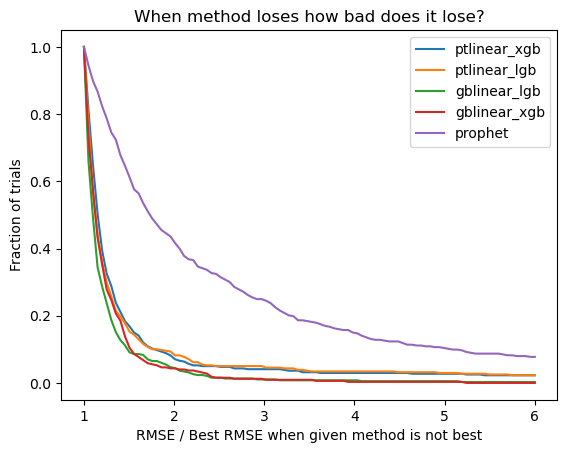

In [78]:
pd.options.display.max_rows=1000

rrr['min'] = rrr[cols].min(1)

def get_ratios(col):
    col_ratio = rrr[col] / rrr['min']

    xgrid = np.linspace(1,6, 100)
    
    res = []
    for x in xgrid:
        res.append({
            'x': x,
            'p': (col_ratio[rrr[col] > rrr['min']] > x).mean()
        })
    res = pd.DataFrame(res)
    return res




res = get_ratios('rmse_ptlinear_xgb')
plt.plot(res['x'], res['p'], label='ptlinear_xgb')
res = get_ratios('rmse_ptlinear_lgb')
plt.plot(res['x'], res['p'], label='ptlinear_lgb')



res = get_ratios('rmse_gblinear_lgb')
plt.plot(res['x'], res['p'], label='gblinear_lgb')

res = get_ratios('rmse_gblinear_xgb')
plt.plot(res['x'], res['p'], label='gblinear_xgb')

res = get_ratios('rmse_prophet')
plt.plot(res['x'], res['p'], label='prophet')

#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('RMSE / Best RMSE when given method is not best')
plt.ylabel('Fraction of trials')
plt.title('When method loses how bad does it lose?')

In [35]:
res

[{'x': 1.0, 'p': 1.0},
 {'x': 1.0505050505050506, 'p': 0.7283950617283951},
 {'x': 1.101010101010101, 'p': 0.5709876543209876},
 {'x': 1.1515151515151516, 'p': 0.43209876543209874},
 {'x': 1.202020202020202, 'p': 0.35185185185185186},
 {'x': 1.2525252525252526, 'p': 0.2777777777777778},
 {'x': 1.303030303030303, 'p': 0.24691358024691357},
 {'x': 1.3535353535353536, 'p': 0.20679012345679013},
 {'x': 1.404040404040404, 'p': 0.18518518518518517},
 {'x': 1.4545454545454546, 'p': 0.1388888888888889},
 {'x': 1.5050505050505052, 'p': 0.10493827160493827},
 {'x': 1.5555555555555556, 'p': 0.08641975308641975},
 {'x': 1.606060606060606, 'p': 0.07716049382716049},
 {'x': 1.6565656565656566, 'p': 0.06790123456790123},
 {'x': 1.7070707070707072, 'p': 0.05864197530864197},
 {'x': 1.7575757575757576, 'p': 0.05555555555555555},
 {'x': 1.808080808080808, 'p': 0.05246913580246913},
 {'x': 1.8585858585858586, 'p': 0.046296296296296294},
 {'x': 1.9090909090909092, 'p': 0.046296296296296294},
 {'x': 1.9595